# Feature Engineering

This is the detailed backup to my submission. It can act as the Appendix of that submission.

Coverage After Transfer = CAT Index

Create BCG graphs: marginal, efficient, athletes, elite. By players on a team (KC), by top players by position. Number of tackles vs CAT. Do it by teams, but instead of number of tackles, it's yards per play. 
USE weeks_predict_categorical AS A BASIS; AROUND LINE 122.

The reason the ballTransferToTackle event ended because there was a body there to stop it. The position of that body has the most affect on the tackle.

How can teams use this?
More detailed than quartiles
Offense vs defense by best and worst teams; other teams stats that are appropriate
Look at details of TransferToTackle

In [321]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import math
pd.set_option('display.float_format', '{:.2f}'.format)

from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
#from sklearn import datasets

import eli5
from eli5.sklearn import PermutationImportance

from matplotlib import pyplot as plt

In [2]:
games = pd.read_csv('./data/games.csv')
players = pd.read_csv('./data/players.csv')
plays = pd.read_csv('./data/plays.csv')
tackles = pd.read_csv('./data/tackles.csv')
week1 = pd.read_csv('./data/tracking_week_1.csv')
week2 = pd.read_csv('./data/tracking_week_2.csv')
week3 = pd.read_csv('./data/tracking_week_3.csv')
week4 = pd.read_csv('./data/tracking_week_4.csv')
week5 = pd.read_csv('./data/tracking_week_5.csv')
week6 = pd.read_csv('./data/tracking_week_6.csv')
week7 = pd.read_csv('./data/tracking_week_7.csv')
week8 = pd.read_csv('./data/tracking_week_8.csv')
week9 = pd.read_csv('./data/tracking_week_9.csv')

To combine all the 9 weeks of tracking data into one dataframe. 

In [3]:
all_weeks = [week1, week2, week3, week4, week5, week6, week7, week8, week9]
weeks = pd.concat(all_weeks)
weeks

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.00,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.00,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.00,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.00,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.00,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.00,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.00,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.00,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.00,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.00,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150018,2022110700,3787,NaN,football,40,2022-11-07 23:06:49.200000,NaN,football,right,26.22,19.68,1.37,2.58,0.15,NaN,NaN,tackle
1150019,2022110700,3787,NaN,football,41,2022-11-07 23:06:49.299999,NaN,football,right,26.32,19.61,1.07,2.74,0.12,NaN,NaN,NaN
1150020,2022110700,3787,NaN,football,42,2022-11-07 23:06:49.400000,NaN,football,right,26.39,19.56,0.80,2.49,0.09,NaN,NaN,NaN
1150021,2022110700,3787,NaN,football,43,2022-11-07 23:06:49.500000,NaN,football,right,26.45,19.52,0.57,2.38,0.07,NaN,NaN,NaN


In [4]:
games

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23
...,...,...,...,...,...,...,...,...,...
131,2022110607,2022,9,11/06/2022,13:00:00,WAS,MIN,17,20
132,2022110608,2022,9,11/06/2022,16:05:00,ARI,SEA,21,31
133,2022110609,2022,9,11/06/2022,16:25:00,TB,LA,16,13
134,2022110610,2022,9,11/06/2022,20:20:00,KC,TEN,20,17


In [5]:
games_weeks = games[['gameId', 'week']]
games_weeks

,gameId,week
0,2022090800,1
1,2022091100,1
2,2022091101,1
3,2022091102,1
4,2022091103,1
...,...,...
131,2022110607,9
132,2022110608,9
133,2022110609,9
134,2022110610,9


In [6]:
players

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan
...,...,...,...,...,...,...,...
1678,55200,6-6,266,NaN,Indiana,DT,Ryder Anderson
1679,55212,6-0,230,NaN,Iowa State,ILB,Jake Hummel
1680,55239,6-2,300,NaN,Pennsylvania,DT,Prince Emili
1681,55240,6-1,185,NaN,Buffalo,CB,Ja'Marcus Ingram


To first convert the players' heights into total inches and then to get the total mass of the players by combining their height and weight. 

In [7]:
players['totalInches'] = (players.height.str.split("-").str[0].astype(int) * 12) + (
    players.height.str.split("-").str[1].astype(int)
)
players['mass'] = (players['totalInches']/12 * players['weight']).round(2)

In [8]:
plays

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.98,0.02,-0.01,0.01,2.36,0.98,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.16,0.84,-0.01,0.01,1.73,-0.26,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.76,0.24,-0.04,0.04,1.31,1.13,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.62,0.38,-0.00,0.00,1.64,-0.04,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.84,0.16,0.00,-0.00,3.69,-0.17,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,(13:31) E.Elliott right tackle to WAS 38 for 1...,1,1,10,DAL,WAS,...,0.64,0.36,-0.01,0.01,3.64,-0.50,NaN,NaN,NaN,NaN
12482,2022091200,3467,46189,Will Dissly,(6:08) G.Smith pass short right to W.Dissly to...,4,1,10,SEA,DEN,...,0.62,0.38,-0.03,0.03,1.43,-0.44,NaN,NaN,NaN,NaN
12483,2022101605,3371,44860,Joe Mixon,(9:35) (Shotgun) J.Mixon left end to CIN 47 fo...,4,1,10,CIN,NO,...,0.67,0.33,-0.01,0.01,2.12,0.20,NaN,NaN,NaN,NaN
12484,2022100207,2777,52449,Jonathan Taylor,(2:02) (Shotgun) J.Taylor up the middle to TEN...,3,1,10,IND,TEN,...,0.41,0.59,-0.05,0.05,3.95,-0.98,NaN,NaN,NaN,NaN


Since playId is "...not unique across games" I'll combine that column and gameId to create a new variable called gamePlayId to have a unique identifier for each play.

In [9]:
plays['gamePlayId'] = plays[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
plays['gamePlayId'] = plays['gamePlayId'].astype('int64')

To add the week number to each of the plays. 

In [10]:
plays = pd.merge(plays, games_weeks, on='gameId', how='left')

To again create the unique gamePlayId value for each play. Since I'll be creating a tackles value later in this work, I've changed the name of the tackle column to tackler. 

In [11]:
tackles['gamePlayId'] = tackles[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
tackles['gamePlayId'] = tackles['gamePlayId'].astype('int64')
tackles.rename(columns={'tackle':'tackler'}, inplace=True)

To add the game week to the plays in the tackles dataframe. 

In [12]:
tackles = pd.merge(tackles, games_weeks, on=['gameId'], how='left')
tackles

,gameId,playId,nflId,tackler,assist,forcedFumble,pff_missedTackle,gamePlayId,week
0,2022090800,101,42816,1,0,0,0,2022090800101,1
1,2022090800,393,46232,1,0,0,0,2022090800393,1
2,2022090800,486,40166,1,0,0,0,2022090800486,1
3,2022090800,646,47939,1,0,0,0,2022090800646,1
4,2022090800,818,40107,1,0,0,0,2022090800818,1
...,...,...,...,...,...,...,...,...,...
17421,2022091113,2494,43533,0,0,0,1,20220911132494,1
17422,2022092502,3510,42406,0,0,0,1,20220925023510,3
17423,2022091113,3642,43478,0,0,0,1,20220911133642,1
17424,2022091901,3578,42431,0,0,0,1,20220919013578,2


To again create the unique gamePlayId value for the weeks dataframe and drop the columns I won't need in the future. 

In [13]:
weeks['gamePlayId'] = weeks[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
weeks['gamePlayId'] = weeks['gamePlayId'].astype('int64')
weeks.drop(columns=['time', 'jerseyNumber', 'playDirection'], inplace=True)

To merge the tackles and players dataframes into the primary weeks dataframe, and then drop some of the players columns I won't need going forward. 

In [14]:
weeks = pd.merge(weeks, tackles, on=['gameId','playId','nflId','gamePlayId'], how='left')
weeks = weeks.drop('week', axis=1)
weeks = pd.merge(weeks, players, on=['nflId','displayName'], how='left')
weeks.drop(['height', 'weight', 'birthDate', 'collegeName'], axis=1, inplace=True)

One of the most important concepts in tackling is how many yards the ball carrier gained after they received the ball, either by a handoff or a caught pass. I'm calling that event a transfer and I'll change the handoff and pass_outcome_caught event values to a transfer. 

Before making this change I want to create a new column called 'playType' to identify pass vs run plays based on these two event types. 

In [15]:
weeks['playType'] = np.where(weeks['event']=='handoff', 'run', 0)
weeks['playType'] = np.where(weeks['event']=='pass_outcome_caught', 'pass', weeks['playType'])

In [16]:
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,...,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType
0,2022090800,56,35472.00,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,0
1,2022090800,56,35472.00,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,...,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,0
2,2022090800,56,35472.00,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,0
3,2022090800,56,35472.00,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,0
4,2022090800,56,35472.00,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,football,40,football,26.22,19.68,1.37,2.58,...,tackle,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12187394,2022110700,3787,NaN,football,41,football,26.32,19.61,1.07,2.74,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12187395,2022110700,3787,NaN,football,42,football,26.39,19.56,0.80,2.49,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12187396,2022110700,3787,NaN,football,43,football,26.45,19.52,0.57,2.38,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# To Expand Play Types To All Rows in Each gamePlayId Group

Initially the play type value is only showing up the frame where it occured. I want to expand that to all the frames in each play. 

In [17]:
weeks_playtype = weeks[['gamePlayId', 'playType']]

In [18]:
weeks_playtype

,gamePlayId,playType
0,202209080056,0
1,202209080056,0
2,202209080056,0
3,202209080056,0
4,202209080056,0
...,...,...
12187393,20221107003787,0
12187394,20221107003787,0
12187395,20221107003787,0
12187396,20221107003787,0


In [19]:
grouped_playtype = weeks_playtype.groupby(['gamePlayId']).max().reset_index()

In [20]:
grouped_playtype

,gamePlayId,playType
0,202209080056,pass
1,202209080080,0
2,202209110057,0
3,202209110078,run
4,202209110185,pass
...,...,...
12481,20221107003658,run
12482,20221107003686,run
12483,20221107003707,run
12484,20221107003740,run


There are still a small number of plays that have not been identified as a run or pass because they didn't contain a handoff or a caught pass. I'm calling these direct plays and assuming they occured from either a quarterback sack, a quarterback run or a run with a direct snap to a running back or receiver. 

In [21]:
grouped_playtype['playType'] = np.where(grouped_playtype['playType']=='0', 'direct', grouped_playtype['playType'])
grouped_playtype['playType'].value_counts()

run       5876
pass      5646
direct     964
Name: playType, dtype: int64

In [22]:
grouped_playtype

,gamePlayId,playType
0,202209080056,pass
1,202209080080,direct
2,202209110057,direct
3,202209110078,run
4,202209110185,pass
...,...,...
12481,20221107003658,run
12482,20221107003686,run
12483,20221107003707,run
12484,20221107003740,run


In [23]:
weeks = pd.merge(weeks, grouped_playtype, on=['gamePlayId'], how='left')
weeks = weeks.drop('playType_x', axis=1)
weeks.rename(columns={'playType_y':'playType'}, inplace=True)
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,...,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType
0,2022090800,56,35472.00,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass
1,2022090800,56,35472.00,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,...,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass
2,2022090800,56,35472.00,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass
3,2022090800,56,35472.00,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass
4,2022090800,56,35472.00,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,...,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,football,40,football,26.22,19.68,1.37,2.58,...,tackle,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run
12187394,2022110700,3787,NaN,football,41,football,26.32,19.61,1.07,2.74,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run
12187395,2022110700,3787,NaN,football,42,football,26.39,19.56,0.80,2.49,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run
12187396,2022110700,3787,NaN,football,43,football,26.45,19.52,0.57,2.38,...,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run


# Developing a Ball Location Metric

I want to be able to track where the ball is at each frame for each play. To do this, I'll initially note the coordinates where the ball is on the frame where the ball carrier ID is the same as the player's NFL ID. 

First, I'll merge the plays and games dataframes into the primary weeks dataframe. 

In [24]:
pd.options.display.max_columns = None
plays.head(5)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gamePlayId,week
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,ATL,41,7:52,21,7,C,6.00,NaN,9,9,N,69,SHOTGUN,7.00,0.75,0.98,0.02,-0.01,0.01,2.36,0.98,NaN,NaN,NaN,NaN,20221009083537,5
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,PIT,34,7:38,14,20,NaN,NaN,NaN,3,3,N,76,SHOTGUN,7.00,0.42,0.16,0.84,-0.01,0.01,1.73,-0.26,NaN,NaN,NaN,NaN,20220911033126,1
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,LV,30,8:57,10,3,C,11.00,NaN,15,15,N,40,I_FORM,6.00,0.27,0.76,0.24,-0.04,0.04,1.31,1.13,NaN,NaN,NaN,NaN,20220911111148,1
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,DEN,37,13:12,19,16,NaN,NaN,NaN,7,7,N,47,SINGLEBACK,6.00,0.59,0.62,0.38,-0.00,0.00,1.64,-0.04,NaN,NaN,NaN,NaN,20221002122007,4
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,TEN,35,8:33,7,7,NaN,NaN,NaN,3,3,N,75,I_FORM,7.00,0.47,0.84,0.16,0.00,-0.00,3.69,-0.17,NaN,NaN,NaN,NaN,20220919001372,2


In [25]:
plays_merge = plays[['gameId','playId','gamePlayId','absoluteYardlineNumber','ballCarrierId','quarter','possessionTeam',
                     'defensiveTeam','playResult', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox']]

In [26]:
plays_merge

,gameId,playId,gamePlayId,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox
0,2022100908,3537,20221009083537,69,48723,4,ATL,TB,9,1,10,SHOTGUN,7.00
1,2022091103,3126,20220911033126,76,52457,4,PIT,CIN,3,1,10,SHOTGUN,7.00
2,2022091111,1148,20220911111148,40,42547,2,LV,LAC,15,2,5,I_FORM,6.00
3,2022100212,2007,20221002122007,47,46461,3,DEN,LV,7,2,10,SINGLEBACK,6.00
4,2022091900,1372,20220919001372,75,47857,2,BUF,TEN,3,1,10,I_FORM,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,2022100204123,49,43293,1,DAL,WAS,1,1,10,SINGLEBACK,6.00
12482,2022091200,3467,20220912003467,40,46189,4,SEA,DEN,2,1,10,SINGLEBACK,7.00
12483,2022101605,3371,20221016053371,69,44860,4,CIN,NO,6,1,10,SHOTGUN,6.00
12484,2022100207,2777,20221002072777,44,52449,3,IND,TEN,-2,1,10,SHOTGUN,6.00


In [27]:
weeks = pd.merge(weeks, plays_merge, on=['gameId','playId','gamePlayId'], how='left')

In [28]:
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox
0,2022090800,56,35472.00,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00
1,2022090800,56,35472.00,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00
2,2022090800,56,35472.00,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00
3,2022090800,56,35472.00,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00
4,2022090800,56,35472.00,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,football,40,football,26.22,19.68,1.37,2.58,0.15,NaN,NaN,tackle,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00
12187394,2022110700,3787,NaN,football,41,football,26.32,19.61,1.07,2.74,0.12,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00
12187395,2022110700,3787,NaN,football,42,football,26.39,19.56,0.80,2.49,0.09,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00
12187396,2022110700,3787,NaN,football,43,football,26.45,19.52,0.57,2.38,0.07,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00


In [29]:
games_merge = games[['gameId', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']]
weeks = pd.merge(weeks, games_merge, on=['gameId'], how='left')
weeks['nflId'] = weeks['nflId'].fillna(0)
weeks['nflId'] = weeks['nflId'].astype(int)
weeks['nflId'].isna().sum()

0

I'll create new a new metric for both the x and y coordinates that identifies where the ball carrier is the same as the NFL ID. This is where the ball is located on the x and y coordinates for a particular frame within a play. 

In [30]:
weeks['xBallLocation'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['x'], 0)
weeks['yBallLocation'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['y'], 0)

In [31]:
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,0.00,0.00
1,2022090800,56,35472,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,0.00,0.00
2,2022090800,56,35472,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,0.00,0.00
3,2022090800,56,35472,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,0.00,0.00
4,2022090800,56,35472,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,0,football,40,football,26.22,19.68,1.37,2.58,0.15,NaN,NaN,tackle,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,0.00,0.00
12187394,2022110700,3787,0,football,41,football,26.32,19.61,1.07,2.74,0.12,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,0.00,0.00
12187395,2022110700,3787,0,football,42,football,26.39,19.56,0.80,2.49,0.09,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,0.00,0.00
12187396,2022110700,3787,0,football,43,football,26.45,19.52,0.57,2.38,0.07,NaN,NaN,NaN,20221107003787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,0.00,0.00


To show the xBallLocation and yBallLocation for all the frames of a particular play. 

In [32]:
weeks['xBallLocation'] = weeks.groupby(['gamePlayId', 'frameId'])['xBallLocation'].transform(max)
weeks['yBallLocation'] = weeks.groupby(['gamePlayId', 'frameId'])['yBallLocation'].transform(max)

I want to track how far each player is on each from from the ball. To do that I'll take create a Ball Distance variable that uses the Pythagorean formula to map the distance each player's combined x and y coordinates are from the combined x and y ball coordinates. When that player is the ball carrier, his distance should be 0. 

In [33]:
weeks['ballDistance'] = np.sqrt((weeks['xBallLocation'] - weeks['x']) ** 2 + (weeks['yBallLocation'] - weeks['y']) ** 2)

This is to eliminate all rows where the play name is "football". 

In [34]:
weeks = weeks[weeks.displayName != 'football']

In [35]:
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48
1,2022090800,56,35472,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.48,37.68,13.23
2,2022090800,56,35472,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.34,37.09,13.01
3,2022090800,56,35472,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.19,36.53,12.81
4,2022090800,56,35472,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.01,36.00,12.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187349,2022110700,3787,55125,Lewis Kidd,40,NO,23.41,21.19,1.60,0.94,0.16,108.00,115.27,tackle,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,3.19
12187350,2022110700,3787,55125,Lewis Kidd,41,NO,23.55,21.12,1.55,0.91,0.16,112.25,118.17,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.34,19.66,3.15
12187351,2022110700,3787,55125,Lewis Kidd,42,NO,23.68,21.04,1.47,0.94,0.15,115.80,120.17,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.40,19.62,3.07
12187352,2022110700,3787,55125,Lewis Kidd,43,NO,23.80,20.96,1.38,1.01,0.14,119.27,123.15,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.42,19.58,2.96


In [36]:
weeks['ballDistance'].describe()

count   11657338.00
mean          11.14
std            9.29
min            0.00
25%            4.28
50%            8.46
75%           16.27
max          104.74
Name: ballDistance, dtype: float64

In [37]:
count = weeks['ballDistance'].lt(1).sum()
print(count)

906197


In [38]:
count = weeks['ballDistance'].lt(.05).sum()
print(count)

526769


In [39]:
count = weeks['ballDistance'].lt(.0001).sum()
print(count)

525986


# Setting Up A Player Direction vs Ball Carrier Direction

One of the aspects that could be important to tackling is the direction of the tacklers compared to the direction of the ball carrier. First, I'll create this dirBallCarrier variable that identifies the direction of the ball carrier of each frame. 

In [40]:
weeks['dirBallCarrier'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['dir'], 0)

Next I'll spread that value to all the frames of a play. 

In [41]:
weeks['dirBallCarrier'] = weeks.groupby(['gamePlayId', 'frameId'])['dirBallCarrier'].transform(max)

Finally, I'll create a dirBallVariance to measure the difference between the ball carrier's direction and every other player of a particular frame. 

In [42]:
weeks['dirBallVariance'] = np.minimum(((weeks['dir'] - weeks['dirBallCarrier']).abs()), (360-(weeks['dir'] - weeks['dirBallCarrier']).abs()))

In physics momentum is speed times mass and force is acceleration times mass. These two values measure the momentum and force of every player. 

In [43]:
weeks['momentum'] = ((weeks['s'] * weeks['mass']).round(2))/1000
weeks['force'] = ((weeks['a'] * weeks['mass']).round(2))/1000

I want to measure the impact of every tackler on the ball carrier as they make their tackles. So the momentum vector and force vectors are the force and momemtum times the variance of the direction the tackler is vs the ball carrier. 

The greater the number should be the greater the impact on the ball carrier. If the tackler was facing the same direction as the ball carrier, then the impact should be small as the are probably tackling the ball carrier from behind. However if they tackle the ball carrier head on, their variance should be the highest number, since they are facing opposite directions, and their impact would be the highest. 

In [44]:
weeks['momemtumVector'] = (weeks['momentum'] * weeks['dirBallVariance']).round()
weeks['forceVector'] = (weeks['force'] * weeks['dirBallVariance']).round()

# Create a Snap Event at FrameId 1

Over half the plays in this dataset do not have a snap event. Since every play from the line of scrimmage in an NFL game has a snap, this is something that needs to be corrected. To keep is simple, I'll just have all snap events occur on the first frame. 

In [45]:
weeks = weeks[weeks.event !='ball_snap']
weeks['event'] = np.where(weeks['frameId']==1, 'snap', weeks['event'])

# Mapping the Distance for Different Events

Like many sports football is about territory. The better a player or a team is at tackling, the less territory they give up. Therefore, one of the key metrics of succesfull tackling is minimizing the number of yards a ball carrier gets after they get the ball, whether it's through a handoff or a catch. So, based on the events in this dataset, the best measure of tackling effectiveness is the number of yards from a ball transfer (handoff or catch) to a tackle. In this section, I'll develop this metric and a number of related metrics. 

In [46]:
weeks

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00
1,2022090800,56,35472,Rodger Saffold,2,BUF,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.48,37.68,13.23,191.08,42.55,3.48,1.27,148.00,54.00
2,2022090800,56,35472,Rodger Saffold,3,BUF,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.34,37.09,13.01,194.40,47.35,3.27,1.02,155.00,48.00
3,2022090800,56,35472,Rodger Saffold,4,BUF,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.19,36.53,12.81,196.97,51.55,3.00,1.86,155.00,96.00
4,2022090800,56,35472,Rodger Saffold,5,BUF,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.01,36.00,12.67,199.54,57.59,2.69,2.59,155.00,149.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187349,2022110700,3787,55125,Lewis Kidd,40,NO,23.41,21.19,1.60,0.94,0.16,108.00,115.27,tackle,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,3.19,121.39,6.12,3.23,1.90,20.00,12.00
12187350,2022110700,3787,55125,Lewis Kidd,41,NO,23.55,21.12,1.55,0.91,0.16,112.25,118.17,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.34,19.66,3.15,120.45,2.28,3.13,1.84,7.00,4.00
12187351,2022110700,3787,55125,Lewis Kidd,42,NO,23.68,21.04,1.47,0.94,0.15,115.80,120.17,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.40,19.62,3.07,125.47,5.30,2.97,1.90,16.00,10.00
12187352,2022110700,3787,55125,Lewis Kidd,43,NO,23.80,20.96,1.38,1.01,0.14,119.27,123.15,NaN,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.42,19.58,2.96,171.35,48.20,2.79,2.04,134.00,98.00


To rename the pass outcomes and handoff events to transfer events. 

In [47]:
weeks['event'] = np.where(weeks['event']=='pass_outcome_caught', 'transfer', weeks['event'])
weeks['event'] = np.where(weeks['event']=='handoff', 'transfer', weeks['event'])
weeks_events = weeks[weeks['event'].notna()]

To drop the events I'm not looking to track. There are a lot of these, but there overall counts are small. 

In [48]:
weeks_events.rename(columns={'tackle':'tackler'}, inplace=True)

In [49]:
drop_events = ['pass_arrived', 'run', 'man_in_motion', 'play_action', 'shift', 'qb_slide', 'pass_forward', 'touchdown', 
               'lateral', 'line_set', 'snap_direct', 'autoevent_ballsnap', 'fumble_offense_recovered', 'run_pass_option', 
               'pass_shovel', 'fumble_defense_recovered', 'qb_sack', 'autoevent_passinterrupted', 'autoevent_passforward',
              'pass_outcome_touchdown','penalty_accepted', 'penalty_flag', 'safety']

In [50]:
weeks_events = weeks_events[~weeks_events.event.isin(drop_events)]

In [51]:
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,NaN,NaN,NaN,NaN,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,16.69,24.58,5.20,143.84,34.17,1.52,2.02,52.00,69.00
12187338,2022110700,3787,55125,Lewis Kidd,29,NO,21.51,21.41,1.68,0.55,0.17,131.55,71.96,first_contact,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,22.56,21.40,1.05,104.41,32.45,3.40,1.11,110.00,36.00


I want to create separate columns for each of the remaining events to I can start tracking the distance between these events, including my ultimate goal of tracking the distance between a transfer and a tackle. I'll use the process of creating dummy variables to do this. 

In [52]:
weeks_events_merge = weeks_events[['gamePlayId', 'event']]

In [53]:
weeks_events_merge

,gamePlayId,event
0,202209080056,snap
5,202209080056,transfer
17,202209080056,tackle
22,202209080056,snap
27,202209080056,transfer
...,...,...
12187305,20221107003787,tackle
12187310,20221107003787,snap
12187324,20221107003787,transfer
12187338,20221107003787,first_contact


In [54]:
event_dummies = pd.get_dummies(weeks_events_merge['event'])

In [55]:
event_dummies

,first_contact,fumble,out_of_bounds,snap,tackle,transfer
0,0,0,0,1,0,0
5,0,0,0,0,0,1
17,0,0,0,0,1,0
22,0,0,0,1,0,0
27,0,0,0,0,0,1
...,...,...,...,...,...,...
12187305,0,0,0,0,1,0
12187310,0,0,0,1,0,0
12187324,0,0,0,0,0,1
12187338,1,0,0,0,0,0


In [56]:
weeks_events_merge = pd.concat([weeks_events_merge, event_dummies], axis=1) 
weeks_events_merge.drop(['event'], inplace=True, axis=1)
weeks_events_merge.drop(['gamePlayId'], inplace=True, axis=1)

In [57]:
weeks_events_merge

,first_contact,fumble,out_of_bounds,snap,tackle,transfer
0,0,0,0,1,0,0
5,0,0,0,0,0,1
17,0,0,0,0,1,0
22,0,0,0,1,0,0
27,0,0,0,0,0,1
...,...,...,...,...,...,...
12187305,0,0,0,0,1,0
12187310,0,0,0,1,0,0
12187324,0,0,0,0,0,1
12187338,1,0,0,0,0,0


In [58]:
weeks_events_merge.apply(pd.Series.value_counts)

,first_contact,fumble,out_of_bounds,snap,tackle,transfer
0,791582,1020998,983488,748682,802406,769384
1,231726,2310,39820,274626,220902,253924


In [59]:
weeks_events = pd.concat([weeks_events, weeks_events_merge], axis=1)

In [60]:
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,NaN,NaN,NaN,NaN,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00,0,0,0,0,1,0
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00,0,0,0,1,0,0
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,16.69,24.58,5.20,143.84,34.17,1.52,2.02,52.00,69.00,0,0,0,0,0,1
12187338,2022110700,3787,55125,Lewis Kidd,29,NO,21.51,21.41,1.68,0.55,0.17,131.55,71.96,first_contact,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,22.56,21.40,1.05,104.41,32.45,3.40,1.11,110.00,36.00,1,0,0,0,0,0


Now I'll want to create new variables to track the x and y coordinates of each of the key remaining events. 

In [61]:
weeks_events['xSnap'] = np.where(weeks_events['snap'] == 1, weeks_events['x'], 0)
weeks_events['ySnap'] = np.where(weeks_events['snap'] == 1, weeks_events['y'], 0)
weeks_events['xContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['x'], 0)
weeks_events['yContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['y'], 0)
weeks_events['xTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['x'], 0)
weeks_events['yTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['y'], 0)
weeks_events['xTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['x'], 0)
weeks_events['yTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['y'], 0)

In [62]:
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,0.00,0.00,0.00,0.00
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,0.00,0.00,0.00,0.00,88.80,26.70,0.00,0.00
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,88.23,27.09
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,0.00,0.00,0.00,0.00
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,0.00,0.00,0.00,0.00,78.11,28.74,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,NaN,NaN,NaN,NaN,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,33.45,29.73
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00,0,0,0,1,0,0,20.17,21.95,0.00,0.00,0.00,0.00,0.00,0.00
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,16.69,24.58,5.20,143.84,34.17,1.52,2.02,52.00,69.00,0,0,0,0,0,1,0.00,0.00,0.00,0.00,20.72,21.29,0.00,0.00
12187338,2022110700,3787,55125,Lewis Kidd,29,NO,21.51,21.41,1.68,0.55,0.17,131.55,71.96,first_contact,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,22.56,21.40,1.05,104.41,32.45,3.40,1.11,110.00,36.00,1,0,0,0,0,0,0.00,0.00,21.51,21.41,0.00,0.00,0.00,0.00


To spread the event locations for each of the players in a play. That can become the basis for how ground they cover between events for each play. 

In [63]:
event_locations = ['xSnap', 'ySnap', 'xContact', 'yContact', 'xTransfer', 'yTransfer', 'xTackle', 'yTackle']
for i in event_locations:
    weeks_events[i] = weeks_events.groupby(['gamePlayId', 'nflId'])[i].transform(max)

In [64]:
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,NaN,NaN,NaN,NaN,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00,0,0,0,0,1,0,32.50,34.76,33.99,33.10,32.96,34.84,33.45,29.73
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00,0,0,0,1,0,0,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,16.69,24.58,5.20,143.84,34.17,1.52,2.02,52.00,69.00,0,0,0,0,0,1,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19
12187338,2022110700,3787,55125,Lewis Kidd,29,NO,21.51,21.41,1.68,0.55,0.17,131.55,71.96,first_contact,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,22.56,21.40,1.05,104.41,32.45,3.40,1.11,110.00,36.00,1,0,0,0,0,0,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19


I want to track how far each play moves between each event in a play. To do that, I'll use the Pythagorean formula to record the distance the player moves from the x, y coordinates at one event to the x, y coordinates of the next event. This is how much ground they cover between these events. 

In [65]:
weeks_events['snapToTransfer'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xTransfer'] > 0),
                                       (np.sqrt((weeks_events['xTransfer'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTransfer'] - weeks_events['ySnap']) ** 2)), 0)

weeks_events['transferToContact'] = np.where((weeks_events['xTransfer'] > 0) & (weeks_events['xContact'] > 0),
                                       (np.sqrt((weeks_events['xContact'] - weeks_events['xTransfer']) ** 2 + (weeks_events['yContact'] - weeks_events['yTransfer']) ** 2)), 0)

weeks_events['transferToTackle'] = np.where((weeks_events['xTransfer'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xTransfer']) ** 2 + (weeks_events['yTackle'] - weeks_events['yTransfer']) ** 2)), 0)

weeks_events['contactToTackle'] = np.where((weeks_events['xContact'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xContact']) ** 2 + (weeks_events['yTackle'] - weeks_events['yContact']) ** 2)), 0)

weeks_events['snapToTackle'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTackle'] - weeks_events['ySnap']) ** 2)), 0)

weeks_events['snapToContact'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xContact'] > 0),
                                       (np.sqrt((weeks_events['xContact'] - weeks_events['xSnap']) ** 2 + (weeks_events['yContact'] - weeks_events['ySnap']) ** 2)), 0)
                                     

In [66]:
weeks_events['transferToTackle'] = np.where((weeks_events['xTransfer'] == 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTackle'] - weeks_events['ySnap']) ** 2)),
                                           weeks_events['transferToTackle'])

In [67]:
team_yards = weeks_events.groupby('defensiveTeam').agg(
    SnapToTransferYards=('snapToTransfer', 'mean'),
    SnapToContactYards=('snapToContact', 'mean'),
    SnapToTackleYards=('snapToTackle', 'mean'),
    TransferToContactYards=('transferToContact', 'mean'),
    ContactToTackleYards=('contactToTackle', 'mean'),
    TransferToTackleYards=('transferToTackle', 'mean')
    
).reset_index()

team_yards_sorted = team_yards.sort_values(by='defensiveTeam')
team_yards_sorted

,defensiveTeam,SnapToTransferYards,SnapToContactYards,SnapToTackleYards,TransferToContactYards,ContactToTackleYards,TransferToTackleYards
0,ARI,1.89,5.22,6.92,3.64,3.00,6.01
1,ATL,1.90,4.77,6.54,3.26,2.84,5.51
2,BAL,1.86,5.08,6.42,3.54,2.76,5.48
3,BUF,1.88,5.35,6.93,3.62,3.01,5.92
4,CAR,1.99,5.23,6.68,3.56,2.85,5.59
5,CHI,1.99,5.85,7.24,4.04,3.05,6.20
6,CIN,2.04,5.40,7.23,3.48,2.81,6.04
7,CLE,1.92,5.48,6.80,3.94,2.89,5.80
8,DAL,1.95,5.33,6.87,3.66,2.64,5.78
9,DEN,1.87,4.73,6.41,3.20,2.85,5.40


In [68]:
ballDistance_yards = weeks_events.groupby('tackler').agg(
    BallDistance=('ballDistance', 'mean'),

    
).reset_index()

ballDistance_yards_sorted = ballDistance_yards.sort_values(by='tackler')
ballDistance_yards_sorted

,tackler,BallDistance
0,0.00,6.11
1,1.00,5.06


In [69]:
ballDistanceAssist_yards = weeks_events.groupby('assist').agg(
    BallDistance=('ballDistance', 'mean'),

    
).reset_index()

ballDistanceAssist_yards_sorted = ballDistanceAssist_yards.sort_values(by='assist')
ballDistanceAssist_yards_sorted

,assist,BallDistance
0,0.00,5.43
1,1.00,5.70


In [70]:
play_yards = weeks_events.groupby('gamePlayId').agg(
    SnapToTransferYards=('snapToTransfer', 'mean'),
    SnapToContactYards=('snapToContact', 'mean'),
    SnapToTackleYards=('snapToTackle', 'mean'),
    TransferToContactYards=('transferToContact', 'mean'),
    ContactToTackleYards=('contactToTackle', 'mean'),
    TransferToTackleYards=('transferToTackle', 'mean')
    
).reset_index()

play_yards_sorted = play_yards.sort_values(by='gamePlayId')
play_yards_sorted.head(15)

,gamePlayId,SnapToTransferYards,SnapToContactYards,SnapToTackleYards,TransferToContactYards,ContactToTackleYards,TransferToTackleYards
0,202209080056,1.44,0.00,4.03,0.00,0.00,2.92
1,202209080080,0.00,5.53,7.66,0.00,2.48,7.66
2,202209110057,0.00,15.52,17.62,0.00,2.55,17.62
3,202209110078,3.38,7.87,8.50,6.87,5.11,9.08
4,202209110185,1.93,2.88,5.89,1.01,3.87,4.66
5,202209110286,2.08,7.11,11.27,5.48,4.97,9.79
6,202209110358,1.76,2.78,5.02,1.08,2.46,3.49
7,202209110382,2.03,0.00,0.00,0.00,0.00,0.00
8,202209110458,2.02,3.59,5.94,1.65,2.58,4.17
9,202209110486,2.38,5.40,32.46,3.71,30.98,32.50


In [71]:
table = pd.pivot_table(weeks_events, values='transferToTackle', index=['defensiveTeam'],
                       columns=['week'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

week,1,2,3,4,5,6,7,8,9,Overall
defensiveTeam,,,,,,,,,,
Overall,5.66,5.94,5.61,5.92,5.76,5.66,5.66,5.74,5.71,5.74
MIA,4.57,5.23,5.33,6.32,6.41,4.11,4.35,5.27,5.97,5.31
DEN,5.25,4.84,6.39,5.31,4.70,5.34,5.45,5.92,NaN,5.40
TEN,5.33,5.44,4.63,5.37,5.55,NaN,5.61,6.34,5.34,5.41
NO,5.95,4.85,6.71,4.22,5.73,4.37,5.55,5.22,6.13,5.42
MIN,5.56,5.07,5.34,5.67,4.80,5.99,NaN,5.04,5.95,5.42
PHI,5.31,5.21,4.68,6.08,5.25,4.76,NaN,5.44,7.11,5.43
NYJ,6.09,6.45,5.09,6.39,6.21,4.71,4.19,5.26,4.51,5.43
BAL,5.33,5.50,5.92,5.05,6.33,6.21,5.01,5.11,4.46,5.48


In [72]:
table = pd.pivot_table(weeks_events, values='transferToTackle', index=['defensiveTeam'],
                       columns=['playType'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

playType,direct,pass,run,Overall
defensiveTeam,,,,
Overall,5.69,4.53,6.85,5.74
MIA,6.23,4.67,5.90,5.31
DEN,5.32,3.89,6.78,5.40
TEN,4.64,4.58,6.67,5.41
NO,5.72,3.83,6.71,5.42
MIN,5.11,4.40,6.63,5.42
PHI,6.44,4.28,6.51,5.43
NYJ,4.67,3.86,6.87,5.43
BAL,3.91,4.64,6.76,5.48


Now I want to track the distance the ball moves for each event. Since the ball is only moving in the x coordinate, I will only utilize the xBallLocation. First, I'll mark where the ball is for each key event. 

In [73]:
weeks_events['xBallSnap'] = np.where(weeks_events['snap'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['xBallLocation'], 0)

In [74]:
pd.options.display.max_columns = None
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,0.00,0.00,0.00
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,0.00,79.85,0.00,0.00
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,0.00,0.00,0.00,79.33
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,0.00,0.00,0.00
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,0.00,79.85,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,NaN,NaN,NaN,NaN,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00,0,0,0,0,1,0,32.50,34.76,33.99,33.10,32.96,34.84,33.45,29.73,0.47,2.02,5.13,3.41,5.12,2.23,0.00,0.00,0.00,26.24
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00,0,0,0,1,0,0,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19,0.86,0.80,2.69,1.91,3.33,1.44,15.85,0.00,0.00,0.00
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,16.69,24.58,5.20,143.84,34.17,1.52,2.02,52.00,69.00,0,0,0,0,0,1,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19,0.86,0.80,2.69,1.91,3.33,1.44,0.00,16.69,0.00,0.00
12187338,2022110700,3787,55125,Lewis Kidd,29,NO,21.51,21.41,1.68,0.55,0.17,131.55,71.96,first_contact,20221107003787,NaN,NaN,NaN,NaN,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,

Next, I will spread the ball location for each event to all the frames of each play. 

In [75]:
events_ball = ['xBallSnap', 'xBallTransfer', 'xBallContact', 'xBallTackle']
for i in events_ball:
    weeks_events[i] = weeks_events.groupby(['gamePlayId'])[i].transform(max)

To eliminate all rows where a tackle didn't occur, since I only want to look at plays where there was a tackle. 

In [76]:
weeks_events = weeks_events[weeks_events['xBallTackle']!=0]

For some plays there was no ball transfer. This means it was a direct play, so I'll have the ball transfer location equal the snap location. Also, there are plays where there is no contact and for these plays, I'll have the contact location equal the tackle location. 

In [77]:
weeks_events['xBallTransfer'] = np.where(weeks_events['xBallTransfer']== 0, weeks_events['xBallSnap'], weeks_events['xBallTransfer'])
weeks_events['xBallContact'] = np.where(weeks_events['xBallContact']== 0, weeks_events['xBallTackle'], weeks_events['xBallContact'])

Finally, I'll create the variables that measure how far the ball moved between each event. Obviously, the lower this value is the better for the defense and the higher, the better for the offense. 

In [78]:
weeks_events['ballSnapToTransfer'] = (weeks_events['xBallTransfer'] - weeks_events['xBallSnap']).abs()
weeks_events['ballSnapToContact'] = (weeks_events['xBallContact'] - weeks_events['xBallSnap']).abs()
weeks_events['ballTransferToContact'] = (weeks_events['xBallContact'] - weeks_events['xBallTransfer']).abs()
weeks_events['ballContactToTackle'] = (weeks_events['xBallTackle'] - weeks_events['xBallContact']).abs()
weeks_events['ballSnapToTackle'] = (weeks_events['xBallTackle'] - weeks_events['xBallSnap']).abs()
weeks_events['ballTransferToTackle'] = (weeks_events['xBallTackle'] - weeks_events['xBallTransfer']).abs()

In [79]:
weeks_events.head(10)

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,NaN,NaN,NaN,NaN,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
39,2022090800,56,38577,Bobby Wagner,18,LA,78.62,32.31,1.76,3.13,0.19,0.84,34.12,tackle,202209080056,NaN,NaN,NaN,NaN,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,1.70,78.02,43.90,2.56,4.54,112.00,200.00,0,0,0,0,1,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
44,2022090800,56,41239,Aaron Donald,1,LA,91.08,31.61,3.91,2.34,0.40,168.33,132.02,snap,202209080056,NaN,NaN,NaN,NaN,DT,73.00,1703.33,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,12.43,189.38,57.36,6.66,3.99,382.00,229.00,0,0,0,1,0,0,91.08,31.61,0.00,0.00,92.15,29.96,91.04,27.66,1.97,0.00,2.55,0.00,3.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
49,2022090800,56,41239,Aaron Donald,6,LA,92.15,29.96,3.62,2.86,0.37,186.16,157.65,transfer,202209080056,NaN,NaN,NaN,NaN,DT,73.00,1703.33,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,13.53,202.20,44.55,6.17,4.87,275.00,217.00,0,0,0,0,0,1,91.08,31.61,0.00,0.00,92.15,29.96,91.04,27.66,1.97,0.00,2.55,0.00,3.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
61,2022090800,56,41239,Aaron Donald,18,LA,91.04,27.66,2.16,1.98,0.22,273.18,263.65,tackle,202209080056

We can see the results by team. These numbers are very high. The average yards from transfer to tackle is over 7. However, the yardage for the events seems to be much higher than the yardage of the play results. In this code I noted that the total play change between the frames is about 50% higher than the actual play results: https://www.kaggle.com/code/twinpilgrim/play-result-not-matching-the-frames-ball-movement. As I mentioned on the code, I'm not sure why. 

In [80]:
table = pd.pivot_table(weeks_events, values='ballTransferToTackle', index=['defensiveTeam'],
                       columns=['playType'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

playType,direct,pass,run,Overall
defensiveTeam,,,,
Overall,9.61,5.03,8.79,7.29
TEN,15.67,4.32,7.75,6.02
MIA,10.05,5.03,7.50,6.56
NO,9.12,3.78,8.35,6.67
NYJ,7.82,4.02,8.47,6.69
BUF,8.96,4.59,8.56,6.81
DEN,12.24,3.72,9.07,6.96
CAR,6.29,4.86,8.64,7.02
ATL,9.18,5.10,8.79,7.03


In [81]:
play_yards = weeks_events.groupby('gamePlayId').agg(
    PlayResult=('playResult', max),
    BallSnapToTransfer=('ballSnapToTransfer', max),
    BallSnapToContact=('ballSnapToContact', max),
    BallSnapToTackle=('ballSnapToTackle', max),
    BallTransferToContact=('ballTransferToContact', max),
    BallContactToTackle=('ballContactToTackle', max),
    BallTransferToTackle=('ballTransferToTackle', max),
    
).reset_index()

play_yards_sorted = play_yards.sort_values(by='gamePlayId')
play_yards_sorted.head(15)

,gamePlayId,PlayResult,BallSnapToTransfer,BallSnapToContact,BallSnapToTackle,BallTransferToContact,BallContactToTackle,BallTransferToTackle
0,202209080056,6,0.75,1.27,1.27,0.52,0.00,0.52
1,202209080080,7,0.00,8.27,10.70,8.27,2.43,10.70
2,202209110057,11,0.00,13.21,16.59,13.21,3.38,16.59
3,202209110078,6,0.78,10.89,13.61,10.11,2.72,12.83
4,202209110185,-5,0.14,0.30,3.11,0.44,2.81,3.25
5,202209110286,3,0.17,5.30,8.20,5.13,2.90,8.03
6,202209110358,3,1.34,2.30,4.51,0.96,2.21,3.17
7,202209110458,-1,1.59,3.15,5.29,1.56,2.14,3.70
8,202209110486,50,2.39,10.47,56.37,8.08,45.90,53.98
9,202209110556,4,0.12,4.61,8.76,4.49,4.15,8.64


In [82]:
team_yards = weeks_events.groupby('defensiveTeam').agg(
    TransferToTackleYards=('transferToTackle', 'mean'),
    BallTransferToTackle=('ballTransferToTackle', 'mean'),
    ForceVector=('forceVector', 'mean')
    
).reset_index()

team_yards_sorted = team_yards.sort_values(by='defensiveTeam')
team_yards_sorted

,defensiveTeam,TransferToTackleYards,BallTransferToTackle,ForceVector
0,ARI,7.33,7.95,161.43
1,ATL,6.53,7.03,161.28
2,BAL,6.92,7.21,162.84
3,BUF,7.08,6.81,167.13
4,CAR,6.92,7.02,154.19
5,CHI,7.52,7.64,155.64
6,CIN,7.19,7.37,152.92
7,CLE,7.20,8.08,156.45
8,DAL,6.94,7.11,160.02
9,DEN,6.48,6.96,163.07


# Set Up the Data for Predictions

If my primary metric to measure the success of tackling is the yards between a transfer and a tackle, then I would want to understand what most impacts this variable. I'll therefore ultimately run a very basic random forest computation on the data and find out which other variables most impacts this value. 

In order to get a prediction, I'll want to have each tackle event for each play on its own row with the appropriate independent variables for each column and the Transfer to Tackle dependent variable as a column. 

In [83]:
weeks_events[['tackler','assist','forcedFumble','pff_missedTackle']] = weeks_events[['tackler','assist','forcedFumble','pff_missedTackle']].fillna(0)

I'll start the process by creating a dataframe where just the tackle events are included. 

In [84]:
weeks_events_tackles = weeks_events[weeks_events['tackle']==1]
weeks_events_tackles = weeks_events_tackles[weeks_events_tackles['defensiveTeam'] == weeks_events_tackles['club']]

I'll create a new variable to account for how many defenders are within 2 yards of the ball carrier when the tackle takes place. This could identify whether there are influencers that impact the tackle but don't officially make the tackle. 

In [85]:
weeks_events_tackles['defenseWithin2'] = (weeks_events_tackles['ballDistance'] < 2).groupby(weeks_events_tackles['gamePlayId']).transform('sum')

In [86]:
weeks_events_tackles

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2
39,2022090800,56,38577,Bobby Wagner,18,LA,78.62,32.31,1.76,3.13,0.19,0.84,34.12,tackle,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,1.70,78.02,43.90,2.56,4.54,112.00,200.00,0,0,0,0,1,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3
61,2022090800,56,41239,Aaron Donald,18,LA,91.04,27.66,2.16,1.98,0.22,273.18,263.65,tackle,202209080056,0.00,0.00,0.00,0.00,DT,73.00,1703.33,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,13.25,78.02,174.37,3.68,3.37,642.00,588.00,0,0,0,0,1,0,91.08,31.61,0.00,0.00,92.15,29.96,91.04,27.66,1.97,0.00,2.55,0.00,3.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3
127,2022090800,56,42816,Troy Hill,18,LA,69.38,10.33,2.91,0.59,0.29,2.85,353.42,tackle,202209080056,0.00,0.00,0.00,0.00,CB,71.00,1088.67,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,25.54,78.02,84.60,3.17,0.64,268.00,54.00,0,0,0,0,1,0,72.34,7.81,0.00,0.00,70.62,7.66,69.38,10.33,1.73,0.00,2.94,0.00,3.89,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3
149,2022090800,56,43294,Jalen Ramsey,18,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0,0,0,0,1,0,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3
171,2022090800,56,43298,Leonard Floyd,18,LA,90.93,31.87,1.37,0.39,0.14,152.86,230.91,tackle,202209080056,0.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.77,78.02,152.89,2.11,0.60,323.00,92.00,0,0,0,0,1,0,91.99,33.78,0.00,0.00,92.11,33.14,90.93,31.87,0.65,0.00,1.73,0.00,2.18,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12186953,2022110700,3787,52627,Geno Stone,40,BAL,33.31,24.13,4.86,2.39,0.50,241.92,217.30,tackle,20221107003787,0.00,0.00,0.00,0.00,SS,71.00,1242.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,8.33,121.39,95.91,6.04,2.97,579.00,285.00,0,0,0,0,1,0,37.03,31.03,36.80,28.88,37.88,30.92,33.31,24.13,0.86,2.31,8.18,5.89,7.84,2.16,15.85,16.69,22.56,26.24,0.84,6.71,5.87,3.68,10.39,9.55,3
12187129,2022110700,3787,53460,Odafe Oweh,40,BAL,22.08,24.32,0.54,0.98,0.06,60.14,80.83,tackle,20221107003787,0.00,0.00,0.00,0.00,OLB,77.00,1617.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,6.20,121.39,40.56,0.87,1.58,35.00,64.00,0,0,0,0,1,0,21.54,28.15,21.30,24.80,21.04,26.82,22.08,24.32,1.42,2.04,2.71,0.92,3.87,3.36,15.85,16.69,22.56,26.24,0.84,6.71,5.87,3.68,10.39,9.55,3
12187173,2022110700,3787,53533,Brandon Stephens,40,BAL,33.19,38.17,5.59,0.41,0.56,190.20,188.24,tackle,20221107

The new average defensive ball distance metric accounts for the average distance of all 11 defensive players from the ball carrier at the time of the tackle. 

In [87]:
weeks_events_tackles['aveDefBallDistance'] = weeks_events_tackles.groupby('gamePlayId')['ballDistance'].transform('mean')

In [88]:
weeks_events_tackles['defenseWithin2'].value_counts()

2     29315
1     26169
3     22363
4     14894
5      8943
6      3982
0      2651
7      1540
8       374
9       187
10       33
Name: defenseWithin2, dtype: int64

In [89]:
weeks_events_tackles.groupby('gamePlayId')['ballDistance'].mean()

gamePlayId
202209080056      9.52
202209080080     10.77
202209110057      8.75
202209110078      5.52
202209110185     13.34
                  ... 
20221107003658    6.89
20221107003686    2.74
20221107003707    4.76
20221107003740    7.62
20221107003787    6.74
Name: ballDistance, Length: 10041, dtype: float64

In [90]:
count = weeks_events_tackles['ballDistance'].lt(2).sum()
count

26896

In [91]:
weeks_events.head(7)

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
39,2022090800,56,38577,Bobby Wagner,18,LA,78.62,32.31,1.76,3.13,0.19,0.84,34.12,tackle,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,1.70,78.02,43.90,2.56,4.54,112.00,200.00,0,0,0,0,1,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
44,2022090800,56,41239,Aaron Donald,1,LA,91.08,31.61,3.91,2.34,0.40,168.33,132.02,snap,202209080056,0.00,0.00,0.00,0.00,DT,73.00,1703.33,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,12.43,189.38,57.36,6.66,3.99,382.00,229.00,0,0,0,1,0,0,91.08,31.61,0.00,0.00,92.15,29.96,91.04,27.66,1.97,0.00,2.55,0.00,3.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52


In [92]:
weeks_events_tackles['aveDefBallDistance'].nunique()

10041

In [93]:
weeks_events['gamePlayId'].nunique()

10041

In [94]:
weeks_events

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle
0,2022090800,56,35472,Rodger Saffold,1,BUF,88.37,27.27,1.62,1.15,0.16,231.74,147.90,snap,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,13.48,189.38,41.48,3.38,2.40,140.00,99.00,0,0,0,1,0,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
5,2022090800,56,35472,Rodger Saffold,6,BUF,88.80,26.70,1.15,1.42,0.12,234.48,139.41,transfer,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,12.61,202.20,62.79,2.40,2.96,151.00,186.00,0,0,0,0,0,1,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
17,2022090800,56,35472,Rodger Saffold,18,BUF,88.23,27.09,1.72,0.26,0.18,288.76,302.08,tackle,202209080056,0.00,0.00,0.00,0.00,G,77.00,2085.42,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.33,33.85,11.18,78.02,135.94,3.59,0.54,488.00,74.00,0,0,0,0,1,0,88.37,27.27,0.00,0.00,88.80,26.70,88.23,27.09,0.71,0.00,0.69,0.00,0.23,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
22,2022090800,56,38577,Bobby Wagner,1,LA,78.25,27.53,1.24,3.81,0.11,4.20,331.67,snap,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,80.60,38.29,11.01,189.38,142.29,1.80,5.53,256.00,787.00,0,0,0,1,0,0,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
27,2022090800,56,38577,Bobby Wagner,6,LA,78.11,28.74,3.35,2.62,0.32,349.47,357.71,transfer,202209080056,0.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,85,42489,1,BUF,LA,6,1,10,SHOTGUN,6.00,1,LA,BUF,79.85,35.59,7.07,202.20,155.51,4.86,3.80,756.00,592.00,0,0,0,0,0,1,78.25,27.53,0.00,0.00,78.11,28.74,78.62,32.31,1.22,0.00,3.61,0.00,4.79,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187305,2022110700,3787,54606,Damarion Williams,40,BAL,33.45,29.73,1.92,2.40,0.21,216.18,191.40,tackle,20221107003787,0.00,0.00,0.00,0.00,CB,69.00,1035.00,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,26.24,19.72,12.34,121.39,70.01,1.99,2.48,139.00,174.00,0,0,0,0,1,0,32.50,34.76,33.99,33.10,32.96,34.84,33.45,29.73,0.47,2.02,5.13,3.41,5.12,2.23,15.85,16.69,22.56,26.24,0.84,6.71,5.87,3.68,10.39,9.55
12187310,2022110700,3787,55125,Lewis Kidd,1,NO,20.17,21.95,0.01,0.01,0.00,125.10,191.53,snap,20221107003787,0.00,0.00,0.00,0.00,G,78.00,2021.50,run,21,43525,4,NO,BAL,5,1,10,SHOTGUN,4.00,9,NO,BAL,15.85,26.00,5.92,81.54,109.99,0.02,0.02,2.00,2.00,0,0,0,1,0,0,20.17,21.95,21.51,21.41,20.72,21.29,23.41,21.19,0.86,0.80,2.69,1.91,3.33,1.44,15.85,16.69,22.56,26.24,0.84,6.71,5.87,3.68,10.39,9.55
12187324,2022110700,3787,55125,Lewis Kidd,15,NO,20.72,21.29,0.75,1.00,0.08,109.96,178.01,transfer,20221107003787,0.00,0.00,0.00,0.

Since there are both solo tacklers and multiple tacklers getting assists on each play I'm going to initially separate them into their own dataframes from primary dataframe and then merge them into an overall dataframe that will be the basis for the predictions. 

In [95]:
weeks_predict_tacklers = weeks_events_tackles.where(weeks_events_tackles['tackler']==1)
weeks_predict_assists = weeks_events_tackles.where(weeks_events_tackles['assist']==1)
weeks_predict_tacklers = weeks_predict_tacklers[weeks_predict_tacklers['gamePlayId'].notna()]
weeks_predict_assists = weeks_predict_assists[weeks_predict_assists['gamePlayId'].notna()]

In [96]:
weeks_predict_tacklers

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance
149,2022090800.00,56.00,43294.00,Jalen Ramsey,18.00,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056.00,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85.00,42489.00,1.00,BUF,LA,6.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0.00,0.00,0.00,0.00,1.00,0.00,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3.00,9.52
1161,2022090800.00,80.00,53532.00,Ernest Jones,26.00,LA,72.96,42.23,5.62,1.95,0.56,336.48,327.47,tackle,202209080080.00,1.00,0.00,0.00,0.00,ILB,74.00,1418.33,direct,79.00,46076.00,1.00,BUF,LA,7.00,2.00,4.00,EMPTY,6.00,1.00,LA,BUF,73.10,42.57,0.37,326.47,1.00,7.97,2.77,8.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,73.89,35.52,74.35,39.26,0.00,0.00,72.96,42.23,0.00,0.00,6.77,3.28,6.77,3.77,83.80,83.80,75.53,73.10,0.00,8.27,8.27,2.43,10.70,10.70,2.00,10.77
1436,2022090800.00,101.00,42816.00,Troy Hill,45.00,LA,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,2022090800101.00,1.00,0.00,0.00,0.00,CB,71.00,1088.67,run,72.00,47857.00,1.00,BUF,LA,7.00,1.00,10.00,I_FORM,6.00,1.00,LA,BUF,66.69,40.15,2.48,251.22,52.92,1.96,5.41,104.00,286.00,0.00,0.00,0.00,0.00,1.00,0.00,64.67,40.76,69.59,41.88,64.88,42.01,69.08,39.50,1.27,4.71,4.89,2.43,4.59,5.05,79.61,79.16,70.62,66.69,0.45,8.99,8.54,3.93,12.92,12.47,2.00,6.90
2384,2022090800.00,122.00,38577.00,Bobby Wagner,29.00,LA,60.31,47.90,3.19,2.90,0.33,245.75,289.12,tackle,2022090800122.00,1.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,65.00,47857.00,1.00,BUF,LA,6.00,2.00,3.00,SHOTGUN,6.00,1.00,LA,BUF,59.89,47.51,0.57,297.47,8.35,4.63,4.21,39.00,35.00,0.00,0.00,0.00,0.00,1.00,0.00,60.07,33.35,62.42,44.97,61.28,35.93,60.31,47.90,2.85,9.11,12.01,3.61,14.55,11.86,68.96,67.89,63.78,59.89,1.07,5.18,4.11,3.89,9.07,8.00,2.00,12.72
4541,2022090800.00,167.00,43298.00,Leonard Floyd,18.00,LA,46.84,25.08,4.16,6.63,0.46,221.59,237.47,tackle,2022090800167.00,1.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,57.00,42489.00,1.00,BUF,LA,12.00,2.00,8.00,EMPTY,6.00,1.00,LA,BUF,45.61,24.07,1.59,242.09,4.62,6.41,10.21,30.00,47.00,0.00,0.00,0.00,0.00,1.00,0.00,52.42,32.11,48.44,26.39,51.35,30.31,46.84,25.08,2.09,4.88,6.91,2.07,8.98,6.97,53.30,51.68,47.77,45.61,1.62,5.53,3.91,2.16,7.69,6.07,3.00,9.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12181684,2022110700.00,3658.00,44871.00,Tanoh Kpassagnon,55.00,NO,64.04,17.39,1.95,2.29,0.21,282.62,196.01,tackle,20221107003658.00,1.00,0.00,0.00,0.00,DE,79.00,1902.58,run,66.00,43362.00,4.00,BAL,NO,2.00,3.00,1.00,PISTOL,7.00,9.00,NO,BAL,63.58,18.65,1.34,165.27,30.74,3.71,4.36,114.00,134.00,0.00,0.00,0.00,0.00,1.00,0.00,65.60,35.11,66.58,22.94,67.25,32.95,64.04,17.39,2.72,10.03,15.89,6.10,17.79,12.21,73.49,72.61,66.65,63.58,0.88,6.84,5.96,3.07,9.91,9.03,3.00,6.89
12183397,2022110700.00,3686.00,48027.00,Kaden Elliss,72.00,NO,57.78,28.05,0.99,1.11,0.10

In [97]:
weeks_predict_assists

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance
3189,2022090800.00,146.00,38577.00,Bobby Wagner,52.00,LA,57.05,21.36,2.16,2.57,0.20,134.16,202.39,tackle,2022090800146.00,0.00,1.00,0.00,0.00,ILB,72.00,1452.00,run,59.00,47857.00,1.00,BUF,LA,2.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,57.06,22.45,1.09,244.65,42.26,3.14,3.73,133.00,158.00,0.00,0.00,0.00,0.00,1.00,0.00,53.77,28.06,58.16,23.74,55.31,26.93,57.05,21.36,1.91,4.28,5.84,2.63,7.46,6.16,64.16,63.16,59.37,57.06,1.00,4.79,3.79,2.31,7.10,6.10,3.00,6.58
3637,2022090800.00,146.00,43335.00,A'Shawn Robinson,52.00,LA,57.74,21.23,1.08,2.23,0.10,112.88,199.03,tackle,2022090800146.00,0.00,1.00,0.00,0.00,DT,76.00,2090.00,run,59.00,47857.00,1.00,BUF,LA,2.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,57.06,22.45,1.40,244.65,45.62,2.26,4.66,103.00,213.00,0.00,0.00,0.00,0.00,1.00,0.00,58.23,32.29,59.19,24.84,60.01,30.51,57.74,21.23,2.52,5.73,9.55,3.89,11.07,7.51,64.16,63.16,59.37,57.06,1.00,4.79,3.79,2.31,7.10,6.10,3.00,6.58
5585,2022090800.00,191.00,47917.00,Greg Gaines,47.00,LA,43.65,41.92,4.67,4.00,0.49,342.67,328.13,tackle,2022090800191.00,0.00,1.00,0.00,0.00,NT,73.00,1898.00,run,45.00,52494.00,1.00,BUF,LA,1.00,1.00,10.00,SINGLEBACK,6.00,1.00,LA,BUF,43.81,42.32,0.43,323.90,4.23,8.86,7.59,37.00,32.00,0.00,0.00,0.00,0.00,1.00,0.00,44.21,23.30,45.44,38.97,45.90,26.07,43.65,41.92,3.24,12.91,16.01,3.45,18.63,15.72,52.15,51.81,45.40,43.81,0.34,6.75,6.41,1.59,8.34,8.00,3.00,5.20
14776,2022090800.00,593.00,47844.00,Taylor Rapp,29.00,LA,75.28,5.00,2.90,3.84,0.31,287.42,214.07,tackle,2022090800593.00,0.00,1.00,0.00,0.00,FS,72.00,1248.00,pass,85.00,42448.00,1.00,BUF,LA,11.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,73.71,5.83,1.78,244.72,30.65,3.62,4.79,111.00,147.00,0.00,0.00,0.00,0.00,1.00,0.00,82.62,19.73,78.39,8.21,82.78,17.08,75.28,5.00,2.65,9.90,14.22,4.47,16.46,12.27,86.54,85.68,77.89,73.71,0.86,8.65,7.79,4.18,12.83,11.97,2.00,13.18
14908,2022090800.00,593.00,48026.00,Nick Scott,29.00,LA,76.09,6.69,0.51,3.94,0.06,123.04,238.10,tackle,2022090800593.00,0.00,1.00,0.00,0.00,SS,71.00,1183.33,pass,85.00,42448.00,1.00,BUF,LA,11.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,73.71,5.83,2.53,244.72,6.62,0.60,4.66,4.00,31.00,0.00,0.00,0.00,0.00,1.00,0.00,69.33,19.48,75.11,8.78,70.64,17.14,76.09,6.69,2.68,9.48,11.79,2.31,14.47,12.16,86.54,85.68,77.89,73.71,0.86,8.65,7.79,4.18,12.83,11.97,2.00,13.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,2022110700.00,3323.00,52627.00,Geno Stone,42.00,BAL,33.69,3.49,0.74,1.94,0.05,324.57,120.69,tackle,20221107003323.00,0.00,1.00,0.00,0.00,SS,71.00,1242.50,pass,23.00,54476.00,4.00,NO,BAL,11.00,3.00,14.00,SHOTGUN,6.00,9.00,NO,BAL,34.00,3.54,0.31,118.20,2.49,0.92,2.41,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,32.32,23.49,30.25,8.59,30.65,20.86,33.69,3.49,3.12,12.28,17.63,6.15,20.05,15.04,20.63,21.33,28.71,34.00,0.70,8.08,7.38,5.29,13.37,12.67,3.00,8.52
12173124,2022110700.00,3401.00,42361.00,Marcus Peters,34.00,BAL,47.14,1

In [487]:
weeks_predict = pd.concat([weeks_predict_tacklers, weeks_predict_assists])
weeks_predict['nfId'] = weeks_predict['nflId'].astype('int64')
weeks_predict['gamePlayId'] = weeks_predict['gamePlayId'].astype('int64')

To count the total tacklers on each play. In general for plays with tacklers, there are 1 total tacklers and for plays with assists there are 2. 

In [488]:
weeks_predict['totalTacklers'] = weeks_predict.groupby('gamePlayId')['gamePlayId'].transform('count')

In [489]:
weeks_predict

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance,nfId,totalTacklers
149,2022090800.00,56.00,43294.00,Jalen Ramsey,18.00,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85.00,42489.00,1.00,BUF,LA,6.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0.00,0.00,0.00,0.00,1.00,0.00,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3.00,9.52,43294,1
1161,2022090800.00,80.00,53532.00,Ernest Jones,26.00,LA,72.96,42.23,5.62,1.95,0.56,336.48,327.47,tackle,202209080080,1.00,0.00,0.00,0.00,ILB,74.00,1418.33,direct,79.00,46076.00,1.00,BUF,LA,7.00,2.00,4.00,EMPTY,6.00,1.00,LA,BUF,73.10,42.57,0.37,326.47,1.00,7.97,2.77,8.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,73.89,35.52,74.35,39.26,0.00,0.00,72.96,42.23,0.00,0.00,6.77,3.28,6.77,3.77,83.80,83.80,75.53,73.10,0.00,8.27,8.27,2.43,10.70,10.70,2.00,10.77,53532,1
1436,2022090800.00,101.00,42816.00,Troy Hill,45.00,LA,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,2022090800101,1.00,0.00,0.00,0.00,CB,71.00,1088.67,run,72.00,47857.00,1.00,BUF,LA,7.00,1.00,10.00,I_FORM,6.00,1.00,LA,BUF,66.69,40.15,2.48,251.22,52.92,1.96,5.41,104.00,286.00,0.00,0.00,0.00,0.00,1.00,0.00,64.67,40.76,69.59,41.88,64.88,42.01,69.08,39.50,1.27,4.71,4.89,2.43,4.59,5.05,79.61,79.16,70.62,66.69,0.45,8.99,8.54,3.93,12.92,12.47,2.00,6.90,42816,1
2384,2022090800.00,122.00,38577.00,Bobby Wagner,29.00,LA,60.31,47.90,3.19,2.90,0.33,245.75,289.12,tackle,2022090800122,1.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,65.00,47857.00,1.00,BUF,LA,6.00,2.00,3.00,SHOTGUN,6.00,1.00,LA,BUF,59.89,47.51,0.57,297.47,8.35,4.63,4.21,39.00,35.00,0.00,0.00,0.00,0.00,1.00,0.00,60.07,33.35,62.42,44.97,61.28,35.93,60.31,47.90,2.85,9.11,12.01,3.61,14.55,11.86,68.96,67.89,63.78,59.89,1.07,5.18,4.11,3.89,9.07,8.00,2.00,12.72,38577,1
4541,2022090800.00,167.00,43298.00,Leonard Floyd,18.00,LA,46.84,25.08,4.16,6.63,0.46,221.59,237.47,tackle,2022090800167,1.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,57.00,42489.00,1.00,BUF,LA,12.00,2.00,8.00,EMPTY,6.00,1.00,LA,BUF,45.61,24.07,1.59,242.09,4.62,6.41,10.21,30.00,47.00,0.00,0.00,0.00,0.00,1.00,0.00,52.42,32.11,48.44,26.39,51.35,30.31,46.84,25.08,2.09,4.88,6.91,2.07,8.98,6.97,53.30,51.68,47.77,45.61,1.62,5.53,3.91,2.16,7.69,6.07,3.00,9.81,43298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,2022110700.00,3323.00,52627.00,Geno Stone,42.00,BAL,33.69,3.49,0.74,1.94,0.05,324.57,120.69,tackle,20221107003323,0.00,1.00,0.00,0.00,SS,71.00,1242.50,pass,23.00,54476.00,4.00,NO,BAL,11.00,3.00,14.00,SHOTGUN,6.00,9.00,NO,BAL,34.00,3.54,0.31,118.20,2.49,0.92,2.41,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,32.32,23.49,30.25,8.59,30.65,20.86,33.69,3.49,3.12,12.28,17.63,6.15,20.05,15.04,20.63,21.33,28.71,34.00,0.70,8.08,7.38,5.29,13.37,12.67,3.00,8.52,52627,2
12173124,2022110700.00,3401.00,42361.00

In [490]:
weeks_predict['displayName'].value_counts()

C.J. Mosley         79
Rashaan Evans       79
Foyesade Oluokun    78
Zaire Franklin      78
Roquan Smith        75
                    ..
Ryan Anderson        1
Percy Butler         1
Christian Ringo      1
Decobie Durant       1
Sam Okuayinonu       1
Name: displayName, Length: 789, dtype: int64

The new tackles variable is to count how many tackles each player has. It will be a count of how many times a player shows up in this dataframe. 

In [491]:
weeks_predict['tackles'] = weeks_predict.groupby('nflId')['nflId'].transform('count')

In [492]:
weeks_predict['position'].value_counts()

ILB    2668
CB     2494
OLB    2006
DT     1453
FS     1446
SS     1416
DE     1237
NT      405
MLB     207
DB       30
Name: position, dtype: int64

In [493]:
weeks_predict['ballDistance'].describe()

count   13392.00
mean        1.06
std         0.88
min         0.01
25%         0.52
50%         0.83
75%         1.29
max        13.60
Name: ballDistance, dtype: float64

In [494]:
weeks_predict['defenseWithin2'].value_counts()

2.00     3352
3.00     2917
1.00     2519
4.00     2094
5.00     1324
6.00      600
0.00      257
7.00      238
8.00       60
9.00       26
10.00       5
Name: defenseWithin2, dtype: int64

In [495]:
weeks_predict['totalTacklers'].value_counts()

2    6714
1    6678
Name: totalTacklers, dtype: int64

In [496]:
weeks_predict['gamePlayId'].value_counts()

20221107003630    2
2022091105643     2
20220911033011    2
20220925041424    2
20220911032955    2
                 ..
20221002122387    1
20221002122366    1
20221002122278    1
20221002122238    1
2022101603224     1
Name: gamePlayId, Length: 10035, dtype: int64

In [497]:
player_yards = weeks_predict.groupby('displayName').agg(
    TransferToTackleYards=('transferToTackle', 'mean'),
    Position=('position', 'max'),
    Tackles=('displayName', 'count'),
    
   
).reset_index()

player_yards_sorted = player_yards.sort_values(by='displayName')
player_yards_sorted.head(15)

,displayName,TransferToTackleYards,Position,Tackles
0,A'Shawn Robinson,5.16,DT,33
1,A.J. Epenesa,7.63,DE,2
2,A.J. Klein,8.76,OLB,4
3,A.J. Parker,8.18,CB,10
4,A.J. Terrell,4.84,CB,24
5,Aaron Donald,5.80,DT,28
6,Aaron Robinson,4.63,CB,5
7,Abdullah Anderson,6.40,DE,10
8,Adam Gotsis,5.14,DE,7
9,Adetokunbo Ogundeji,7.22,OLB,14


In [498]:
weeks_predict_matrix = weeks_predict.copy()

In [499]:
print([*weeks_predict])

['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'club', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'gamePlayId', 'tackler', 'assist', 'forcedFumble', 'pff_missedTackle', 'position', 'totalInches', 'mass', 'playType', 'absoluteYardlineNumber', 'ballCarrierId', 'quarter', 'possessionTeam', 'defensiveTeam', 'playResult', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'xBallLocation', 'yBallLocation', 'ballDistance', 'dirBallCarrier', 'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'first_contact', 'fumble', 'out_of_bounds', 'snap', 'tackle', 'transfer', 'xSnap', 'ySnap', 'xContact', 'yContact', 'xTransfer', 'yTransfer', 'xTackle', 'yTackle', 'snapToTransfer', 'transferToContact', 'transferToTackle', 'contactToTackle', 'snapToTackle', 'snapToContact', 'xBallSnap', 'xBallTransfer', 'xBallContact', 'xBallTackle', 'ballSnapToTransfer', 'ballSnapToContact', 'ballTransferToContact', 'ballContactToTac

In [500]:
columnsKeep = ['gamePlayId', 'tackler', 'assist','mass', 'playType', 'absoluteYardlineNumber', 'quarter', 'defensiveTeam',
               'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'ballDistance', 'playResult',
               'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'snapToTransfer',
               'transferToContact', 'transferToTackle', 'contactToTackle', 'snapToTackle', 'snapToContact',
               'ballTransferToTackle', 'defenseWithin2', 'aveDefBallDistance', 'totalTacklers', 'tackles']

In [501]:
weeks_predict = weeks_predict.reindex(columnsKeep,axis="columns")

In [502]:
weeks_predict

,gamePlayId,tackler,assist,mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,defendersInTheBox,ballDistance,playResult,dirBallVariance,momentum,force,momemtumVector,forceVector,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles
149,202209080056,1.00,0.00,1265.33,pass,85.00,1.00,LA,1.00,10.00,SHOTGUN,6.00,0.67,6.00,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26
1161,202209080080,1.00,0.00,1418.33,direct,79.00,1.00,LA,2.00,4.00,EMPTY,6.00,0.37,7.00,1.00,7.97,2.77,8.00,3.00,0.00,0.00,6.77,3.28,6.77,3.77,10.70,2.00,10.77,1,46
1436,2022090800101,1.00,0.00,1088.67,run,72.00,1.00,LA,1.00,10.00,I_FORM,6.00,2.48,7.00,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17
2384,2022090800122,1.00,0.00,1452.00,pass,65.00,1.00,LA,2.00,3.00,SHOTGUN,6.00,0.57,6.00,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61
4541,2022090800167,1.00,0.00,1540.00,pass,57.00,1.00,LA,2.00,8.00,EMPTY,6.00,1.59,12.00,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,20221107003323,0.00,1.00,1242.50,pass,23.00,4.00,BAL,3.00,14.00,SHOTGUN,6.00,0.31,11.00,2.49,0.92,2.41,2.00,6.00,3.12,12.28,17.63,6.15,20.05,15.04,12.67,3.00,8.52,2,15
12173124,20221107003401,0.00,1.00,1182.00,pass,41.00,4.00,BAL,2.00,10.00,SHOTGUN,6.00,1.49,9.00,13.76,2.30,0.98,32.00,13.00,1.61,0.00,3.81,0.00,2.24,0.00,1.85,3.00,12.51,2,11
12173808,20221107003401,0.00,1.00,1035.00,pass,41.00,4.00,BAL,2.00,10.00,SHOTGUN,6.00,1.55,9.00,27.14,2.03,2.55,55.00,69.00,1.70,0.00,4.49,0.00,6.19,0.00,1.85,3.00,12.51,2,17
12180122,20221107003630,0.00,1.00,1242.00,run,75.00,4.00,NO,2.00,10.00,PISTOL,6.00,0.96,9.00,56.51,0.97,2.36,55.00,133.00,1.42,8.18,7.28,3.85,8.58,9.60,15.44,3.00,6.90,2,21


In [503]:
weeks_predict['offenseFormation'].value_counts()

SHOTGUN       6486
SINGLEBACK    4139
I_FORM        1113
EMPTY          782
PISTOL         656
JUMBO          110
WILDCAT        103
Name: offenseFormation, dtype: int64

In [504]:
print([*weeks_predict])

['gamePlayId', 'tackler', 'assist', 'mass', 'playType', 'absoluteYardlineNumber', 'quarter', 'defensiveTeam', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'ballDistance', 'playResult', 'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'snapToTransfer', 'transferToContact', 'transferToTackle', 'contactToTackle', 'snapToTackle', 'snapToContact', 'ballTransferToTackle', 'defenseWithin2', 'aveDefBallDistance', 'totalTacklers', 'tackles']


In [505]:
averageValues = ['tackler', 'assist', 'mass', 'ballDistance', 'dirBallVariance', 'momentum', 'force', 'momemtumVector',
                 'forceVector', 'snapToTransfer', 'transferToContact', 'transferToTackle', 'contactToTackle',
                 'snapToTackle', 'snapToContact', 'defendersInTheBox', 'ballTransferToTackle', 'playResult']

In [506]:
for i in averageValues:
    weeks_predict[i] = weeks_predict.groupby(['gamePlayId'])[i].transform('mean')
    
weeks_predict = weeks_predict.drop_duplicates('gamePlayId', keep='first')
weeks_predict.rename(columns={col: 'ave_' + col for col in weeks_predict.columns if col in averageValues}, inplace=True)

In [507]:
weeks_predict

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_playResult,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_transferToTackle,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ave_ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles
149,202209080056,1.00,0.00,1265.33,pass,85.00,1.00,LA,1.00,10.00,SHOTGUN,6.00,0.67,6.00,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26
1161,202209080080,1.00,0.00,1418.33,direct,79.00,1.00,LA,2.00,4.00,EMPTY,6.00,0.37,7.00,1.00,7.97,2.77,8.00,3.00,0.00,0.00,6.77,3.28,6.77,3.77,10.70,2.00,10.77,1,46
1436,2022090800101,1.00,0.00,1088.67,run,72.00,1.00,LA,1.00,10.00,I_FORM,6.00,2.48,7.00,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17
2384,2022090800122,1.00,0.00,1452.00,pass,65.00,1.00,LA,2.00,3.00,SHOTGUN,6.00,0.57,6.00,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61
4541,2022090800167,1.00,0.00,1540.00,pass,57.00,1.00,LA,2.00,8.00,EMPTY,6.00,1.59,12.00,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140438,20221107002096,0.00,1.00,1341.25,pass,45.00,3.00,NO,1.00,20.00,PISTOL,6.00,1.24,23.00,17.96,1.82,4.71,34.00,76.50,1.91,2.23,5.13,3.28,6.54,4.05,5.14,2.00,16.43,2,64
12150622,20221107002440,0.00,1.00,1761.62,direct,55.00,3.00,BAL,1.00,10.00,WILDCAT,7.00,2.28,6.00,76.50,2.43,5.39,111.00,361.00,0.00,0.00,5.48,2.98,5.48,2.93,11.80,3.00,5.53,2,21
12171983,20221107003323,0.00,1.00,1311.25,pass,23.00,4.00,BAL,3.00,14.00,SHOTGUN,6.00,0.58,11.00,13.99,1.29,3.48,22.00,61.00,3.30,11.96,18.31,7.01,21.09,15.03,12.67,3.00,8.52,2,75
12173124,20221107003401,0.00,1.00,1108.50,pass,41.00,4.00,BAL,2.00,10.00,SHOTGUN,6.00,1.52,9.00,20.45,2.17,1.76,43.50,41.00,1.66,0.00,4.15,0.00,4.21,0.00,1.85,3.00,12.51,2,11


In [508]:
weeks_predict.isnull().sum()

gamePlayId                   0
ave_tackler                  0
ave_assist                   0
ave_mass                    14
playType                     0
absoluteYardlineNumber       0
quarter                      0
defensiveTeam                0
down                         0
yardsToGo                    0
offenseFormation             3
ave_defendersInTheBox        3
ave_ballDistance             0
ave_playResult               0
ave_dirBallVariance          0
ave_momentum                14
ave_force                   14
ave_momemtumVector          14
ave_forceVector             14
ave_snapToTransfer           0
ave_transferToContact        0
ave_transferToTackle         0
ave_contactToTackle          0
ave_snapToTackle             0
ave_snapToContact            0
ave_ballTransferToTackle     0
defenseWithin2               0
aveDefBallDistance           0
totalTacklers                0
tackles                      0
dtype: int64

In [509]:
weeks_predict = weeks_predict.fillna(0)

In [510]:
weeks_predict['playType'].value_counts()

run       5337
pass      4131
direct     567
Name: playType, dtype: int64

In [511]:
weeks_predict.dtypes

gamePlayId                    int64
ave_tackler                 float64
ave_assist                  float64
ave_mass                    float64
playType                     object
absoluteYardlineNumber      float64
quarter                     float64
defensiveTeam                object
down                        float64
yardsToGo                   float64
offenseFormation             object
ave_defendersInTheBox       float64
ave_ballDistance            float64
ave_playResult              float64
ave_dirBallVariance         float64
ave_momentum                float64
ave_force                   float64
ave_momemtumVector          float64
ave_forceVector             float64
ave_snapToTransfer          float64
ave_transferToContact       float64
ave_transferToTackle        float64
ave_contactToTackle         float64
ave_snapToTackle            float64
ave_snapToContact           float64
ave_ballTransferToTackle    float64
defenseWithin2              float64
aveDefBallDistance          

In [512]:
formations = weeks_predict[['ave_defendersInTheBox', 'offenseFormation', 'ave_ballTransferToTackle', 'defensiveTeam']]

In [513]:
weeks_predict_categorical = weeks_predict.copy()

To set up categorical variables for random forest. If non-tree based machine learning algorithm was chosen, then one hot encoding would be used here. 

In [514]:
weeks_predict['playType'] = pd.factorize(weeks_predict['playType'], sort=True)[0]
weeks_predict['defensiveTeam'] = pd.factorize(weeks_predict['defensiveTeam'], sort=True)[0]
weeks_predict['offenseFormation'] = pd.factorize(weeks_predict['offenseFormation'], sort=True)[0]

In [515]:
weeks_predict['playType'].value_counts()

2    5337
1    4131
0     567
Name: playType, dtype: int64

# Predict Ball Transfer To Tackle

In [516]:
weeks_predict

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_playResult,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_transferToTackle,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ave_ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles
149,202209080056,1.00,0.00,1265.33,1,85.00,1.00,16,1.00,10.00,5,6.00,0.67,6.00,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26
1161,202209080080,1.00,0.00,1418.33,0,79.00,1.00,16,2.00,4.00,1,6.00,0.37,7.00,1.00,7.97,2.77,8.00,3.00,0.00,0.00,6.77,3.28,6.77,3.77,10.70,2.00,10.77,1,46
1436,2022090800101,1.00,0.00,1088.67,2,72.00,1.00,16,1.00,10.00,2,6.00,2.48,7.00,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17
2384,2022090800122,1.00,0.00,1452.00,1,65.00,1.00,16,2.00,3.00,5,6.00,0.57,6.00,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61
4541,2022090800167,1.00,0.00,1540.00,1,57.00,1.00,16,2.00,8.00,1,6.00,1.59,12.00,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140438,20221107002096,0.00,1.00,1341.25,1,45.00,3.00,22,1.00,20.00,4,6.00,1.24,23.00,17.96,1.82,4.71,34.00,76.50,1.91,2.23,5.13,3.28,6.54,4.05,5.14,2.00,16.43,2,64
12150622,20221107002440,0.00,1.00,1761.62,0,55.00,3.00,2,1.00,10.00,7,7.00,2.28,6.00,76.50,2.43,5.39,111.00,361.00,0.00,0.00,5.48,2.98,5.48,2.93,11.80,3.00,5.53,2,21
12171983,20221107003323,0.00,1.00,1311.25,1,23.00,4.00,2,3.00,14.00,5,6.00,0.58,11.00,13.99,1.29,3.48,22.00,61.00,3.30,11.96,18.31,7.01,21.09,15.03,12.67,3.00,8.52,2,75
12173124,20221107003401,0.00,1.00,1108.50,1,41.00,4.00,2,2.00,10.00,5,6.00,1.52,9.00,20.45,2.17,1.76,43.50,41.00,1.66,0.00,4.15,0.00,4.21,0.00,1.85,3.00,12.51,2,11


In [521]:
X = weeks_predict.drop(['gamePlayId', 'ave_ballTransferToTackle', 'ave_ballTransferToTackle', 'ave_playResult'],axis=1)
y = weeks_predict.ave_ballTransferToTackle
X.shape, y.shape

((10035, 27), (10035,))

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7526, 27), (2509, 27), (7526,), (2509,))

In [523]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.46568662535810673


In [524]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.6616 ± 0.0309,ave_transferToTackle
0.2549 ± 0.0325,ave_transferToContact
0.1610 ± 0.0111,playType
0.0718 ± 0.0131,ave_mass
0.0524 ± 0.0076,aveDefBallDistance
0.0503 ± 0.0134,ave_snapToTransfer
0.0489 ± 0.0025,ave_snapToTackle
0.0339 ± 0.0010,ave_contactToTackle
0.0094 ± 0.0030,ave_ballDistance
0.0077 ± 0.0025,ave_snapToContact


In [525]:
weeks_predict['ave_ballTransferToTackle'].describe()

count   10035.00
mean        7.21
std         5.98
min         0.00
25%         3.05
50%         6.40
75%         9.66
max        76.54
Name: ave_ballTransferToTackle, dtype: float64

In [526]:
weeks_predict['ave_ballTransferToTackleQuartiles'] = (
    pd.qcut(weeks_predict['ave_ballTransferToTackle'], 4, labels=['Under 3.05', '3.05-6.40', '6.40-9.66', 'Over 9.66'])
)

In [527]:
weeks_predict['ave_ballTransferToTackleQuartiles'].value_counts()

Under 3.05    2509
3.05-6.40     2509
Over 9.66     2509
6.40-9.66     2508
Name: ave_ballTransferToTackleQuartiles, dtype: int64

In [528]:
bins = pd.qcut(weeks_predict['ave_ballTransferToTackle'], 8).cat.categories.tolist()
weeks_predict['ave_ballTransferToTackleEighths'] = pd.cut(weeks_predict['ave_ballTransferToTackle'], bins=pd.IntervalIndex(bins))

In [529]:
transferToTackle_quartiles = weeks_predict.groupby('ave_ballTransferToTackleQuartiles').agg(
    TransferToTackle=('ave_transferToTackle', 'mean'),
    PlayType=('playType', 'mean'),
    Mass=('ave_mass', 'mean'),
    Force=('ave_force', 'mean'),
    Momentum=('ave_momentum', 'mean'),
    DirectionVariance=('ave_dirBallVariance', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

transferToTackle_sorted = transferToTackle_quartiles.sort_values(by='ave_ballTransferToTackleQuartiles')
transferToTackle_sorted

,ave_ballTransferToTackleQuartiles,TransferToTackle,PlayType,Mass,Force,Momentum,DirectionVariance,DefBallDistance
0,Under 3.05,4.67,1.11,1337.67,3.84,3.67,35.52,12.97
1,3.05-6.40,6.47,1.53,1489.26,3.33,2.96,37.15,8.49
2,6.40-9.66,7.24,1.69,1532.12,3.50,2.94,35.48,6.90
3,Over 9.66,12.18,1.57,1398.50,4.06,3.73,29.74,8.18


In [137]:
transferToTackle_eighths = weeks_predict.groupby('ballTransferToTackleEighths').agg(
    TransferToTackle=('ave_transferToTackle', 'mean'),
    PlayType=('playType', 'mean'),
    Mass=('ave_mass', 'mean'),
    Force=('ave_force', 'mean'),
    Momentum=('ave_momentum', 'mean'),
    DirectionVariance=('ave_dirBallVariance', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

transferToTackle_sorted = transferToTackle_eighths.sort_values(by='ballTransferToTackleEighths')
transferToTackle_sorted

,ballTransferToTackleEighths,TransferToTackle,PlayType,Mass,Force,Momentum,DirectionVariance,DefBallDistance
0,"(-0.001, 1.22]",3.91,1.07,1304.50,3.99,3.95,34.62,13.96
1,"(1.22, 3.045]",5.44,1.15,1370.87,3.69,3.38,36.43,11.98
2,"(3.045, 4.83]",6.29,1.42,1468.34,3.36,3.01,37.81,9.21
3,"(4.83, 6.4]",6.65,1.64,1510.12,3.29,2.91,36.50,7.78
4,"(6.4, 7.95]",6.86,1.67,1535.92,3.41,2.89,36.17,7.08
5,"(7.95, 9.66]",7.61,1.71,1528.34,3.59,3.00,34.80,6.73
6,"(9.66, 12.62]",9.37,1.64,1455.87,3.86,3.39,31.24,7.22
7,"(12.62, 76.54]",15.00,1.50,1340.98,4.26,4.08,28.23,9.13


In [530]:
table = pd.pivot_table(weeks_predict, values='ave_transferToTackle', index=['ave_ballTransferToTackleQuartiles'],
                       columns=['playType'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

playType,0,1,2,Overall
ave_ballTransferToTackleQuartiles,,,,
Overall,8.99,7.17,7.86,7.64
Under 3.05,4.37,4.20,7.47,4.67
3.05-6.40,7.18,7.11,5.99,6.47
6.40-9.66,8.02,9.62,6.48,7.24
Over 9.66,11.82,15.69,11.05,12.18


In [531]:
weeks_predict['offenseFormation'].value_counts()

5    4972
6    2979
2     799
1     640
4     489
3      80
7      73
0       3
Name: offenseFormation, dtype: int64

In [532]:
length = weeks_predict.shape[0]
x = weeks_predict['ave_transferToTackle']
y = weeks_predict['ave_ballTransferToTackle']
x = x.values.reshape(length, 1)
y = y.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x, y)
lnr.score(x, y)

0.40809162310851865

In [533]:
print(lnr.coef_[0], lnr.intercept_)

[0.64009712] [2.32236963]


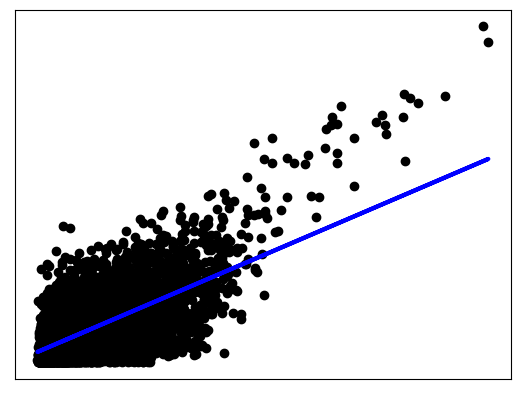

In [534]:
plt.scatter(x, y,  color='black')
plt.plot(x, lnr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [535]:
length = weeks_predict.shape[0]
x = weeks_predict['ave_ballTransferToTackle']
y = weeks_predict['ave_playResult']
x = x.values.reshape(length, 1)
y = y.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x, y)
lnr.score(x, y)

0.16657045252396274

In [562]:
length = weeks_predict.shape[0]
x = weeks_predict['ave_ballTransferToTackle']
y = weeks_predict['tackles']
x = x.values.reshape(length, 1)
y = y.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x, y)
lnr.score(x, y)

0.0002800189793499275

# Breakout for Run vs Pass Plays

For run plays

In [537]:
weeks_predict_run = weeks_predict[weeks_predict.playType==2]

In [538]:
weeks_predict_run

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_playResult,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_transferToTackle,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ave_ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles,ave_ballTransferToTackleQuartiles,ave_ballTransferToTackleEighths
1436,2022090800101,1.00,0.00,1088.67,2,72.00,1.00,16,1.00,10.00,2,6.00,2.48,7.00,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17,Over 9.66,"(9.66, 12.62]"
5789,2022090800191,0.50,0.50,1757.50,2,45.00,1.00,16,1.00,10.00,6,6.00,0.71,1.00,2.76,5.52,5.12,20.00,17.50,2.04,11.49,13.58,2.29,14.94,12.96,8.00,3.00,5.20,2,10,6.40-9.66,"(7.95, 9.66]"
8001,2022090800299,1.00,0.00,1665.58,2,27.00,1.00,3,1.00,10.00,6,6.00,1.24,5.00,21.18,2.85,3.95,60.00,84.00,2.75,4.61,10.18,5.62,12.56,7.15,10.69,5.00,2.97,1,12,Over 9.66,"(9.66, 12.62]"
8589,2022090800343,1.00,0.00,1604.17,2,27.00,1.00,3,2.00,10.00,5,6.00,0.37,2.00,93.87,3.42,1.78,321.00,167.00,1.04,0.00,2.61,0.00,2.58,0.00,6.66,1.00,5.65,1,60,6.40-9.66,"(6.4, 7.95]"
10173,2022090800393,1.00,0.00,1925.00,2,52.00,1.00,3,1.00,10.00,5,6.00,1.20,1.00,0.51,3.23,3.68,2.00,2.00,1.38,1.18,4.96,3.88,5.09,2.09,5.88,4.00,3.22,1,6,3.05-6.40,"(4.83, 6.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12103401,2022110700443,0.00,1.00,1514.66,2,34.00,1.00,22,1.00,10.00,4,7.00,1.00,4.00,11.56,2.76,5.18,40.00,67.00,1.43,2.12,4.26,3.45,3.46,2.75,9.81,4.00,6.15,2,40,Over 9.66,"(9.66, 12.62]"
12106440,2022110700546,0.00,1.00,1302.50,2,61.00,1.00,22,1.00,10.00,4,6.00,1.31,4.00,30.83,0.90,2.88,25.50,116.50,0.61,2.94,5.29,3.65,5.58,3.51,10.01,4.00,6.98,2,33,Over 9.66,"(9.66, 12.62]"
12116188,2022110700950,0.00,1.00,1815.09,2,73.00,2.00,22,2.00,6.00,5,6.00,0.89,2.00,39.68,0.85,2.18,18.00,61.00,1.07,1.34,3.36,2.46,3.28,2.00,6.42,6.00,5.01,2,30,6.40-9.66,"(6.4, 7.95]"
12139048,20221107002064,0.00,1.00,1377.25,2,55.00,3.00,22,1.00,10.00,4,6.00,0.82,-10.00,18.71,1.02,3.10,20.00,59.50,1.76,8.86,10.70,2.52,12.19,10.36,10.34,4.00,4.99,2,21,Over 9.66,"(9.66, 12.62]"


In [539]:
X = weeks_predict_run.drop(['gamePlayId', 'ave_ballTransferToTackle', 'ave_ballTransferToTackleQuartiles', 'ave_ballTransferToTackleEighths', 'ave_playResult'],axis=1)
y = weeks_predict_run.ave_ballTransferToTackle
X.shape, y.shape

((5337, 27), (5337,))

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4002, 27), (1335, 27), (4002,), (1335,))

In [541]:
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.4166779972935491


In [542]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5974 ± 0.0285,ave_transferToTackle
0.1207 ± 0.0183,ave_mass
0.0643 ± 0.0064,ave_snapToTackle
0.0582 ± 0.0120,aveDefBallDistance
0.0573 ± 0.0145,ave_contactToTackle
0.0429 ± 0.0078,ave_transferToContact
0.0133 ± 0.0062,ave_ballDistance
0.0122 ± 0.0035,ave_snapToContact
0.0080 ± 0.0061,ave_force
0.0072 ± 0.0036,ave_snapToTransfer


In [543]:
bins = pd.qcut(weeks_predict_run['ave_ballTransferToTackle'], 8).cat.categories.tolist()
weeks_predict_run['ave_ballTransferToTackleEighths'] = pd.cut(weeks_predict_run['ave_ballTransferToTackle'], bins=pd.IntervalIndex(bins))

In [544]:
transferToTackle_eighths = weeks_predict_run.groupby('ave_ballTransferToTackleEighths').agg(
    TransferToTackle=('ave_transferToTackle', 'mean'),
    SnapToTackle=('ave_snapToTackle', 'mean'),
    Mass=('ave_mass', 'mean'),
    ContactToTackle=('ave_contactToTackle', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

transferToTackle_sorted = transferToTackle_eighths.sort_values(by='ave_ballTransferToTackleEighths')
transferToTackle_sorted

,ave_ballTransferToTackleEighths,TransferToTackle,SnapToTackle,Mass,ContactToTackle,DefBallDistance
0,"(-0.001, 4.09]",6.94,8.85,1607.75,3.44,6.88
1,"(4.09, 5.62]",5.92,7.41,1584.25,2.90,5.75
2,"(5.62, 6.77]",5.82,7.07,1602.83,2.68,5.60
3,"(6.77, 7.91]",6.18,7.21,1593.29,2.95,5.30
4,"(7.91, 9.08]",6.81,7.65,1587.19,3.21,5.29
5,"(9.08, 10.57]",7.57,8.34,1547.84,3.60,5.31
6,"(10.57, 13.32]",9.05,9.56,1456.90,4.31,5.78
7,"(13.32, 76.54]",14.61,14.96,1320.69,7.78,7.63


In [545]:
transferToTackle_quartiles = weeks_predict_run.groupby('ave_ballTransferToTackleQuartiles').agg(
    TransferToTackle=('ave_transferToTackle', 'mean'),
    PlayType=('playType', 'mean'),
    Mass=('ave_mass', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean'),
    Force=('ave_force', 'mean'),
    Momentum=('ave_momentum', 'mean')
    
).reset_index()

# Sort teams by total tackles in descending order
transferToTackle_sorted = transferToTackle_quartiles.sort_values(by='ave_ballTransferToTackleQuartiles')

transferToTackle_sorted

,ave_ballTransferToTackleQuartiles,TransferToTackle,PlayType,Mass,DefBallDistance,Force,Momentum
0,Under 3.05,7.47,2.00,1614.30,7.42,3.35,3.27
1,3.05-6.40,5.99,2.00,1591.42,5.81,2.94,2.53
2,6.40-9.66,6.48,2.00,1591.22,5.31,3.28,2.67
3,Over 9.66,11.05,2.00,1416.53,6.44,3.85,3.39


In [546]:
length = weeks_predict_run.shape[0]
x_run = weeks_predict_run['ave_transferToTackle']
y_run = weeks_predict_run['ave_ballTransferToTackle']
x_run = x_run.values.reshape(length, 1)
y_run = y_run.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x_run, y_run)
lnr.score(x_run, y_run)

0.33417048376096326

In [547]:
print(lnr.coef_[0], lnr.intercept_)

[0.54260887] [4.51033796]


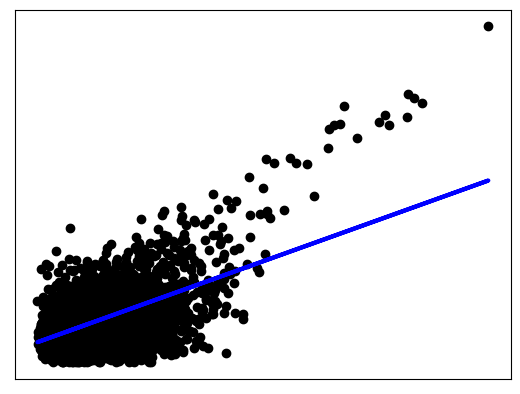

In [548]:
plt.scatter(x_run, y_run,  color='black')
plt.plot(x_run, lnr.predict(x_run), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

For pass plays

In [549]:
weeks_predict_pass = weeks_predict[weeks_predict.playType==1]

In [550]:
weeks_predict_pass

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_playResult,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_transferToTackle,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ave_ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles,ave_ballTransferToTackleQuartiles,ave_ballTransferToTackleEighths
149,202209080056,1.00,0.00,1265.33,1,85.00,1.00,16,1.00,10.00,5,6.00,0.67,6.00,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26,Under 3.05,"(-0.001, 1.22]"
2384,2022090800122,1.00,0.00,1452.00,1,65.00,1.00,16,2.00,3.00,5,6.00,0.57,6.00,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61,6.40-9.66,"(7.95, 9.66]"
4541,2022090800167,1.00,0.00,1540.00,1,57.00,1.00,16,2.00,8.00,1,6.00,1.59,12.00,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31,3.05-6.40,"(4.83, 6.4]"
6076,2022090800212,1.00,0.00,1452.00,1,44.00,1.00,16,2.00,9.00,5,6.00,0.14,8.00,11.14,9.87,6.08,110.00,68.00,4.27,1.72,4.71,2.99,8.96,5.99,2.38,1.00,17.79,1,61,Under 3.05,"(1.22, 3.045]"
11362,2022090800414,1.00,0.00,1094.58,1,53.00,1.00,3,2.00,9.00,1,5.00,3.03,10.00,130.46,2.82,3.72,368.00,486.00,2.15,9.81,11.00,1.69,10.84,9.92,12.60,1.00,14.71,1,21,Over 9.66,"(9.66, 12.62]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12107696,2022110700588,0.00,1.00,1206.00,1,63.00,1.00,22,3.00,8.00,5,5.00,2.18,10.00,81.72,1.97,3.38,71.50,197.50,1.34,1.15,7.17,6.38,8.15,2.48,3.77,2.00,8.61,2,21,3.05-6.40,"(3.045, 4.83]"
12109375,2022110700646,0.00,1.00,1529.84,1,70.00,1.00,22,2.00,13.00,1,5.00,0.99,12.00,10.54,2.59,4.88,28.00,52.00,1.63,0.00,14.19,0.00,15.72,0.00,0.37,4.00,5.09,2,30,Under 3.05,"(-0.001, 1.22]"
12140438,20221107002096,0.00,1.00,1341.25,1,45.00,3.00,22,1.00,20.00,4,6.00,1.24,23.00,17.96,1.82,4.71,34.00,76.50,1.91,2.23,5.13,3.28,6.54,4.05,5.14,2.00,16.43,2,64,3.05-6.40,"(4.83, 6.4]"
12171983,20221107003323,0.00,1.00,1311.25,1,23.00,4.00,2,3.00,14.00,5,6.00,0.58,11.00,13.99,1.29,3.48,22.00,61.00,3.30,11.96,18.31,7.01,21.09,15.03,12.67,3.00,8.52,2,75,Over 9.66,"(12.62, 76.54]"


In [551]:
X = weeks_predict_pass.drop(['gamePlayId', 'ave_ballTransferToTackle', 'ave_ballTransferToTackleQuartiles', 'ave_ballTransferToTackleEighths', 'ave_playResult'],axis=1)
y = weeks_predict_pass.ave_ballTransferToTackle
X.shape, y.shape

((4131, 27), (4131,))

In [552]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3098, 27), (1033, 27), (3098,), (1033,))

In [553]:
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.5019262072302708


In [554]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.7635 ± 0.0324,ave_transferToTackle
0.5068 ± 0.0498,ave_transferToContact
0.0468 ± 0.0101,ave_snapToContact
0.0447 ± 0.0044,ave_snapToTackle
0.0356 ± 0.0104,ave_contactToTackle
0.0137 ± 0.0050,ave_snapToTransfer
0.0117 ± 0.0056,ave_ballDistance
0.0062 ± 0.0034,aveDefBallDistance
0.0053 ± 0.0029,ave_mass
0.0017 ± 0.0030,ave_force


In [555]:
bins = pd.qcut(weeks_predict_pass['ave_ballTransferToTackle'], 8).cat.categories.tolist()
weeks_predict_pass['ave_ballTransferToTackleEighths'] = pd.cut(weeks_predict_pass['ave_ballTransferToTackle'], bins=pd.IntervalIndex(bins))

In [556]:
transferToTackle_eighths = weeks_predict_pass.groupby('ave_ballTransferToTackleEighths').agg(
    TransferToTackle=('ave_transferToTackle', 'mean'),
    TransferToContact=('ave_transferToContact', 'mean'),
    Mass=('ave_mass', 'mean'),
    Force=('ave_force', 'mean'),
    Momentum=('ave_momentum', 'mean'),
    ballDistance=('ave_ballDistance', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

transferToTackle_sorted = transferToTackle_eighths.sort_values(by='ave_ballTransferToTackleEighths')
transferToTackle_sorted

,ave_ballTransferToTackleEighths,TransferToTackle,TransferToContact,Mass,Force,Momentum,ballDistance,DefBallDistance
0,"(-0.001, 0.49]",3.09,0.84,1264.22,4.16,4.22,0.85,14.79
1,"(0.49, 1.11]",3.79,1.30,1275.47,3.97,3.91,0.82,14.59
2,"(1.11, 1.92]",4.50,1.48,1272.33,3.95,3.62,0.95,14.39
3,"(1.92, 3.08]",5.41,2.20,1292.08,3.88,3.51,1.05,13.45
4,"(3.08, 4.61]",6.30,2.90,1333.14,3.85,3.55,1.18,12.74
5,"(4.61, 6.745]",8.26,4.48,1316.48,3.98,3.56,1.20,12.37
6,"(6.745, 10.127]",9.84,5.76,1331.92,4.06,3.56,1.24,11.70
7,"(10.127, 72.93]",16.18,9.67,1339.12,4.48,4.32,1.28,12.21


In [557]:
length = weeks_predict_pass.shape[0]
x_pass = weeks_predict_pass['ave_transferToTackle']
y_pass = weeks_predict_pass['ave_ballTransferToTackle']
x_pass = x_pass.values.reshape(length, 1)
y_pass = y_pass.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x_pass, y_pass)
lnr.score(x_pass, y_pass)

0.5911952135606282

In [558]:
print(lnr.coef_[0], lnr.intercept_)

[0.73797416] [-0.42018649]


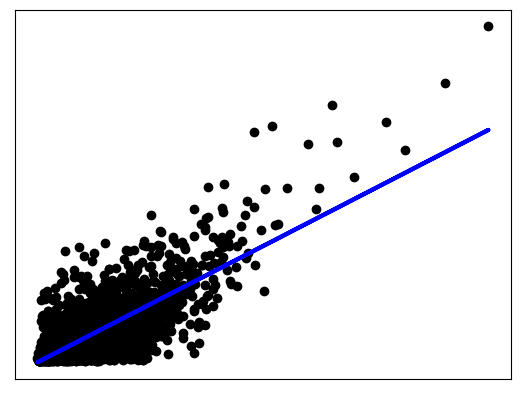

In [559]:
plt.scatter(x_pass, y_pass,  color='black')
plt.plot(x_pass, lnr.predict(x_pass), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# Look At Most Impactful for Transfer To Tackle

In [560]:
weeks_predict_transferToTackle = weeks_predict.copy()

In [561]:
weeks_predict_transferToTackle = weeks_predict_transferToTackle.drop(columns=['ave_contactToTackle', 'ave_snapToTackle',
                                                                             'ave_snapToContact', 'ave_ballTransferToTackle',
                                                                             'ave_transferToContact', 
                                                                              'ave_ballTransferToTackleQuartiles',
                                                                              'ave_ballTransferToTackleEighths',
                                                                             'ave_playResult'])

In [401]:
weeks_predict_transferToTackle.head(5)

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles
149,202209080056,1.00,0.00,1265.33,1,85.00,1.00,16,1.00,10.00,5,6.00,0.67,49.72,1.39,4.01,69.00,199.00,2.94,4.01,3.00,9.52,1,26
1161,202209080080,1.00,0.00,1418.33,0,79.00,1.00,16,2.00,4.00,1,6.00,0.37,1.00,7.97,2.77,8.00,3.00,0.00,6.77,2.00,10.77,1,46
1436,2022090800101,1.00,0.00,1088.67,2,72.00,1.00,16,1.00,10.00,2,6.00,2.48,52.92,1.96,5.41,104.00,286.00,1.27,4.89,2.00,6.90,1,17
2384,2022090800122,1.00,0.00,1452.00,1,65.00,1.00,16,2.00,3.00,5,6.00,0.57,8.35,4.63,4.21,39.00,35.00,2.85,12.01,2.00,12.72,1,61
4541,2022090800167,1.00,0.00,1540.00,1,57.00,1.00,16,2.00,8.00,1,6.00,1.59,4.62,6.41,10.21,30.00,47.00,2.09,6.91,3.00,9.81,1,31


In [402]:
X = weeks_predict_transferToTackle.drop(['gamePlayId', 'ave_transferToTackle'],axis=1)
y = weeks_predict_transferToTackle.ave_transferToTackle
X.shape, y.shape

((10035, 22), (10035,))

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7526, 22), (2509, 22), (7526,), (2509,))

In [404]:
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.5495531115624814


In [405]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.8164 ± 0.0808,playType
0.2465 ± 0.0396,aveDefBallDistance
0.2230 ± 0.0335,ave_momentum
0.2213 ± 0.0497,ave_snapToTransfer
0.0970 ± 0.0201,ave_mass
0.0948 ± 0.0153,ave_force
0.0375 ± 0.0102,defenseWithin2
0.0187 ± 0.0089,ave_ballDistance
0.0155 ± 0.0046,ave_dirBallVariance
0.0079 ± 0.0035,ave_momemtumVector


In [406]:
bins = pd.qcut(weeks_predict_transferToTackle['ave_transferToTackle'], 8).cat.categories.tolist()
weeks_predict_transferToTackle['transferToTackleEighths'] = pd.cut(weeks_predict_transferToTackle['ave_transferToTackle'], bins=pd.IntervalIndex(bins))

In [407]:
transferToTackle_quartiles = weeks_predict_transferToTackle.groupby('transferToTackleEighths').agg(
    PlayType=('playType', 'mean'),
    Momentum=('ave_momentum', 'mean'),
    Force=('ave_force', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

transferToTackle_sorted = transferToTackle_quartiles.sort_values(by='transferToTackleEighths')
transferToTackle_sorted

,transferToTackleEighths,PlayType,Momentum,Force,DefBallDistance
0,"(0.0661, 2.465]",1.31,2.96,3.21,10.74
1,"(2.465, 3.632]",1.46,2.60,3.02,8.38
2,"(3.632, 4.774]",1.53,2.81,3.18,8.37
3,"(4.774, 6.056]",1.54,2.76,3.43,8.32
4,"(6.056, 7.588]",1.57,3.20,3.67,8.47
5,"(7.588, 9.852]",1.51,3.41,3.88,8.86
6,"(9.852, 13.955]",1.44,3.93,4.24,9.32
7,"(13.955, 68.764]",1.45,4.93,4.84,10.61


# Looking At Overall Positions

In [408]:
weeks_predict_positions = weeks_predict_matrix.copy()

In [410]:
weeks_predict_positions = weeks_predict_positions[['nflId', 'transferToTackle', 'tackles', 'position', 'ballTransferToTackle']]

In [411]:
weeks_predict_positions.groupby('position')['nflId'].value_counts()

position  nflId   
CB        52546.00    44
          52411.00    40
          54500.00    40
          46190.00    38
          54504.00    38
                      ..
SS        43413.00     2
          44818.00     2
          54937.00     2
          42376.00     1
          46378.00     1
Name: nflId, Length: 785, dtype: int64

In [412]:
weeks_predict_positions['ave_transferToTackle'] = weeks_predict_positions.groupby('position')['transferToTackle'].transform('mean')
weeks_predict_positions['ave_tackles'] = weeks_predict_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_positions['ave_ballTransferToTackle'] = weeks_predict_positions.groupby('position')['ballTransferToTackle'].transform('mean')

In [413]:
weeks_predict_positions

,nflId,transferToTackle,tackles,position,ballTransferToTackle,ave_transferToTackle,ave_tackles,ave_ballTransferToTackle
149,43294.00,4.01,26,CB,0.52,7.05,21.43,6.65
1161,53532.00,6.77,46,ILB,10.70,7.73,50.05,7.09
1436,42816.00,4.89,17,CB,12.47,7.05,21.43,6.65
2384,38577.00,12.01,61,ILB,8.00,7.73,50.05,7.09
4541,43298.00,6.91,31,DE,6.07,7.37,17.52,7.19
...,...,...,...,...,...,...,...,...
12172167,52627.00,17.63,15,SS,12.67,8.60,34.24,8.55
12173124,42361.00,3.81,11,CB,1.85,7.05,21.43,6.65
12173808,54606.00,4.49,17,CB,1.85,7.05,21.43,6.65
12180122,44851.00,7.28,21,FS,15.44,8.50,32.20,8.74


In [414]:
weeks_predict_positions = weeks_predict_positions.drop_duplicates('position', keep='first')
weeks_predict_positions = weeks_predict_positions.drop('transferToTackle', axis=1)
weeks_predict_positions = weeks_predict_positions.drop('tackles', axis=1)
weeks_predict_positions = weeks_predict_positions.drop('ballTransferToTackle', axis=1)
weeks_predict_positions = weeks_predict_positions[weeks_predict_positions['position'].notna()]

In [415]:
weeks_predict_positions

,nflId,position,ave_transferToTackle,ave_tackles,ave_ballTransferToTackle
149,43294.00,CB,7.05,21.43,6.65
1161,53532.00,ILB,7.73,50.05,7.09
4541,43298.00,DE,7.37,17.52,7.19
5789,52492.00,OLB,7.97,30.54,7.20
10173,46232.00,DT,6.44,18.95,7.10
12278,40166.00,SS,8.60,34.24,8.55
17864,40107.00,FS,8.50,32.20,8.74
122934,38607.00,MLB,8.23,31.74,7.52
284898,47973.00,NT,6.33,18.53,7.10
1054053,52416.00,DB,10.55,30.00,8.05


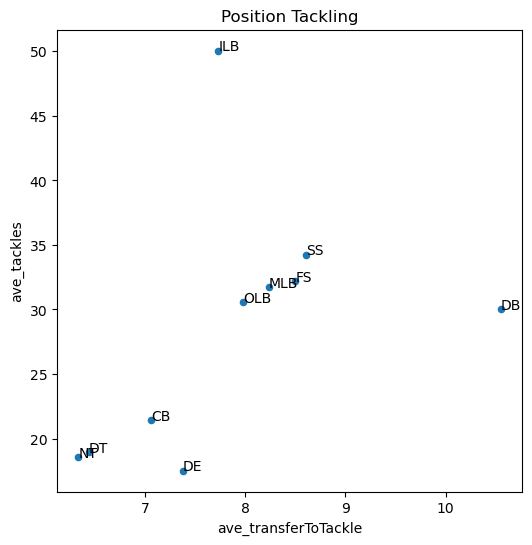

In [416]:
ax = weeks_predict_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_tackles', title='Position Tackling',
                          figsize=(6,6))
weeks_predict_positions[['ave_transferToTackle','ave_tackles','position']].apply(lambda row: ax.text(*row),axis=1);

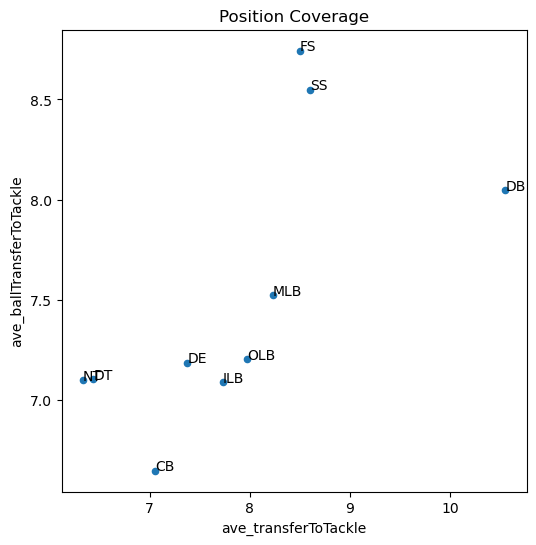

In [417]:
ax = weeks_predict_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Position Coverage',
                          figsize=(6,6))
weeks_predict_positions[['ave_transferToTackle','ave_ballTransferToTackle','position']].apply(lambda row: ax.text(*row),axis=1);

In [418]:
weeks_predict_run_positions = weeks_predict_matrix[weeks_predict_matrix['playType']=='run']
weeks_predict_pass_positions = weeks_predict_matrix[weeks_predict_matrix['playType']=='pass']

In [419]:
weeks_predict_run_positions = weeks_predict_run_positions[['transferToTackle', 'tackles', 'position', 'ballTransferToTackle']]
weeks_predict_run_positions['ave_transferToTackle'] = weeks_predict_run_positions.groupby('position')['transferToTackle'].transform('mean')
weeks_predict_run_positions['ave_ballTransferToTackle'] = weeks_predict_run_positions.groupby('position')['ballTransferToTackle'].transform('mean')
weeks_predict_run_positions['ave_tackles'] = weeks_predict_run_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_run_positions = weeks_predict_run_positions.drop_duplicates('position', keep='first')
weeks_predict_run_positions = weeks_predict_run_positions.drop('transferToTackle', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions.drop('ballTransferToTackle', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions.drop('tackles', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions[weeks_predict_run_positions['position'].notna()]

In [420]:
weeks_predict_pass_positions = weeks_predict_pass_positions[['transferToTackle', 'tackles', 'position', 'ballTransferToTackle']]
weeks_predict_pass_positions['ave_transferToTackle'] = weeks_predict_pass_positions.groupby('position')['transferToTackle'].transform('mean')
weeks_predict_pass_positions['ave_ballTransferToTackle'] = weeks_predict_pass_positions.groupby('position')['ballTransferToTackle'].transform('mean')
weeks_predict_pass_positions['ave_tackles'] = weeks_predict_pass_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_pass_positions = weeks_predict_pass_positions.drop_duplicates('position', keep='first')
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('transferToTackle', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('ballTransferToTackle', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('tackles', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions[weeks_predict_pass_positions['position'].notna()]

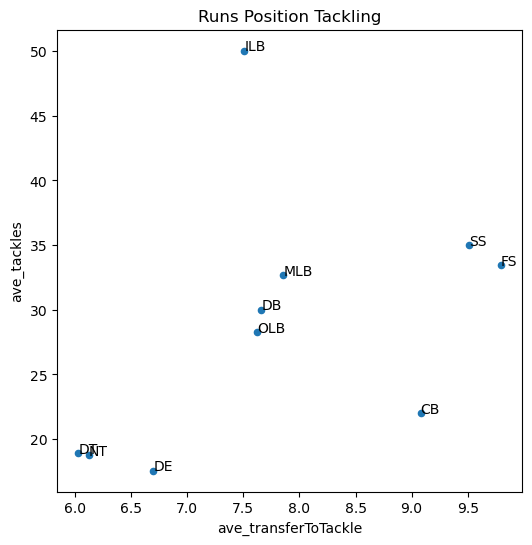

In [421]:
ax = weeks_predict_run_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_tackles', title='Runs Position Tackling',
                          figsize=(6,6))
weeks_predict_run_positions[['ave_transferToTackle','ave_tackles','position']].apply(lambda row: ax.text(*row),axis=1);

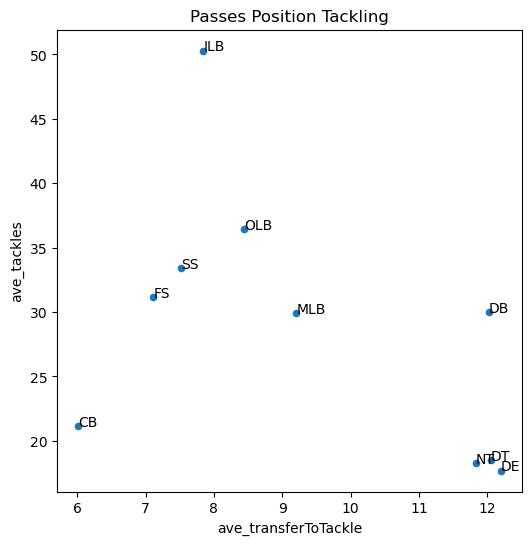

In [422]:
ax = weeks_predict_pass_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_tackles', title='Passes Position Tackling',
                          figsize=(6,6))
weeks_predict_pass_positions[['ave_transferToTackle','ave_tackles','position']].apply(lambda row: ax.text(*row),axis=1);

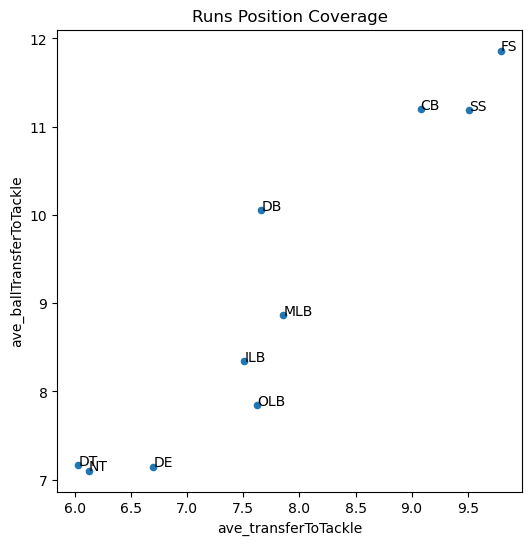

In [423]:
ax = weeks_predict_run_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Runs Position Coverage',
                          figsize=(6,6))
weeks_predict_run_positions[['ave_transferToTackle','ave_ballTransferToTackle','position']].apply(lambda row: ax.text(*row),axis=1);

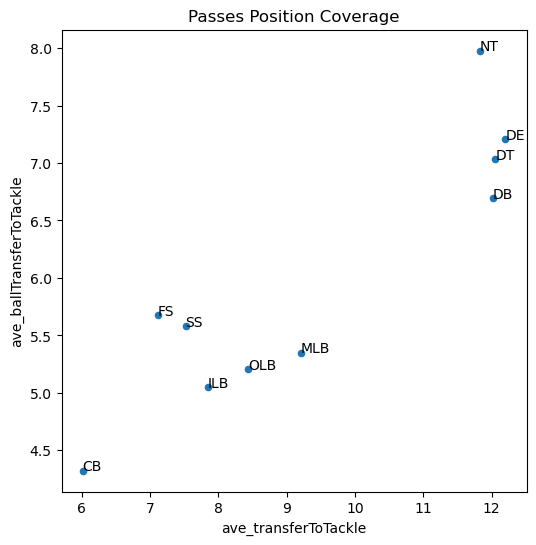

In [424]:
ax = weeks_predict_pass_positions.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Passes Position Coverage',
                          figsize=(6,6))
weeks_predict_pass_positions[['ave_transferToTackle','ave_ballTransferToTackle','position']].apply(lambda row: ax.text(*row),axis=1);

# Looking at Players Within A Position

In [250]:
weeks_predict_matrix

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance,nfId,totalTacklers,tackles
149,2022090800.00,56.00,43294.00,Jalen Ramsey,18.00,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85.00,42489.00,1.00,BUF,LA,6.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0.00,0.00,0.00,0.00,1.00,0.00,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3.00,9.52,43294,1,26
1161,2022090800.00,80.00,53532.00,Ernest Jones,26.00,LA,72.96,42.23,5.62,1.95,0.56,336.48,327.47,tackle,202209080080,1.00,0.00,0.00,0.00,ILB,74.00,1418.33,direct,79.00,46076.00,1.00,BUF,LA,7.00,2.00,4.00,EMPTY,6.00,1.00,LA,BUF,73.10,42.57,0.37,326.47,1.00,7.97,2.77,8.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,73.89,35.52,74.35,39.26,0.00,0.00,72.96,42.23,0.00,0.00,6.77,3.28,6.77,3.77,83.80,83.80,75.53,73.10,0.00,8.27,8.27,2.43,10.70,10.70,2.00,10.77,53532,1,46
1436,2022090800.00,101.00,42816.00,Troy Hill,45.00,LA,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,2022090800101,1.00,0.00,0.00,0.00,CB,71.00,1088.67,run,72.00,47857.00,1.00,BUF,LA,7.00,1.00,10.00,I_FORM,6.00,1.00,LA,BUF,66.69,40.15,2.48,251.22,52.92,1.96,5.41,104.00,286.00,0.00,0.00,0.00,0.00,1.00,0.00,64.67,40.76,69.59,41.88,64.88,42.01,69.08,39.50,1.27,4.71,4.89,2.43,4.59,5.05,79.61,79.16,70.62,66.69,0.45,8.99,8.54,3.93,12.92,12.47,2.00,6.90,42816,1,17
2384,2022090800.00,122.00,38577.00,Bobby Wagner,29.00,LA,60.31,47.90,3.19,2.90,0.33,245.75,289.12,tackle,2022090800122,1.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,65.00,47857.00,1.00,BUF,LA,6.00,2.00,3.00,SHOTGUN,6.00,1.00,LA,BUF,59.89,47.51,0.57,297.47,8.35,4.63,4.21,39.00,35.00,0.00,0.00,0.00,0.00,1.00,0.00,60.07,33.35,62.42,44.97,61.28,35.93,60.31,47.90,2.85,9.11,12.01,3.61,14.55,11.86,68.96,67.89,63.78,59.89,1.07,5.18,4.11,3.89,9.07,8.00,2.00,12.72,38577,1,61
4541,2022090800.00,167.00,43298.00,Leonard Floyd,18.00,LA,46.84,25.08,4.16,6.63,0.46,221.59,237.47,tackle,2022090800167,1.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,57.00,42489.00,1.00,BUF,LA,12.00,2.00,8.00,EMPTY,6.00,1.00,LA,BUF,45.61,24.07,1.59,242.09,4.62,6.41,10.21,30.00,47.00,0.00,0.00,0.00,0.00,1.00,0.00,52.42,32.11,48.44,26.39,51.35,30.31,46.84,25.08,2.09,4.88,6.91,2.07,8.98,6.97,53.30,51.68,47.77,45.61,1.62,5.53,3.91,2.16,7.69,6.07,3.00,9.81,43298,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,2022110700.00,3323.00,52627.00,Geno Stone,42.00,BAL,33.69,3.49,0.74,1.94,0.05,324.57,120.69,tackle,20221107003323,0.00,1.00,0.00,0.00,SS,71.00,1242.50,pass,23.00,54476.00,4.00,NO,BAL,11.00,3.00,14.00,SHOTGUN,6.00,9.00,NO,BAL,34.00,3.54,0.31,118.20,2.49,0.92,2.41,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,32.32,23.49,30.25,8.59,30.65,20.86,33.69,3.49,3.12,12.28,17.63,6.15,20.05,15.04,20.63,21.33,28.71,34.00,0.70,8.08,7.38,5.29,13.37,12.67,3.00,8.52,52627,2,15
12173124,

In [251]:
weeks_predict_matrix.groupby('position')['nflId'].value_counts()

position  nflId   
CB        52546.00    44
          52411.00    40
          54500.00    40
          46190.00    38
          54504.00    38
                      ..
SS        43413.00     2
          44818.00     2
          54937.00     2
          42376.00     1
          46378.00     1
Name: nflId, Length: 785, dtype: int64

In [252]:
weeks_predict_players = weeks_predict_matrix.copy()

In [253]:
weeks_predict_players = weeks_predict_players[['nflId', 'position']]

In [254]:
weeks_predict_players

,nflId,position
149,43294.00,CB
1161,53532.00,ILB
1436,42816.00,CB
2384,38577.00,ILB
4541,43298.00,DE
...,...,...
12172167,52627.00,SS
12173124,42361.00,CB
12173808,54606.00,CB
12180122,44851.00,FS


In [255]:
weeks_predict_players = weeks_predict_players.drop_duplicates('nflId', keep='first')

In [256]:
weeks_predict_players['position'].value_counts()

CB     175
OLB    131
DT     118
DE     110
ILB     85
FS      65
SS      61
NT      29
MLB     10
DB       1
Name: position, dtype: int64

In [257]:
weeks_predict_mlb = weeks_predict_matrix[weeks_predict_matrix['position']=='MLB']

In [258]:
weeks_predict_mlb

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance,nfId,totalTacklers,tackles
122934,2022091100.00,1651.00,38607.00,Demario Davis,44.00,NO,43.92,27.73,3.25,2.42,0.34,201.45,216.90,tackle,20220911001651,1.00,0.00,0.00,0.00,MLB,74.00,1529.33,run,47.00,39975.00,2.00,ATL,NO,4.00,1.00,10.00,SINGLEBACK,7.00,1.00,ATL,NO,42.98,27.69,0.94,206.50,10.40,4.97,3.70,52.00,38.00,0.00,0.00,0.00,0.00,1.00,0.00,41.78,27.48,45.25,30.41,43.04,30.56,43.92,27.73,3.33,2.22,2.96,2.99,2.15,4.54,54.53,52.41,44.81,42.98,2.12,9.72,7.60,1.83,11.55,9.43,5.00,4.57,38607,2,40
135697,2022091100.00,2353.00,38607.00,Demario Davis,43.00,NO,55.15,9.98,1.85,2.90,0.20,2.74,163.21,tackle,20220911002353,1.00,0.00,0.00,0.00,MLB,74.00,1529.33,run,55.00,39975.00,3.00,ATL,NO,1.00,1.00,10.00,PISTOL,7.00,1.00,ATL,NO,55.68,10.02,0.53,170.34,7.13,2.83,4.44,20.00,32.00,0.00,0.00,0.00,0.00,1.00,0.00,59.91,23.12,55.00,13.53,58.61,21.11,55.15,9.98,2.39,8.40,11.66,3.55,13.98,10.77,47.47,48.68,54.12,55.68,1.21,6.65,5.44,1.56,8.21,7.00,3.00,8.08,38607,1,40
171629,2022091100.00,4266.00,38607.00,Demario Davis,23.00,NO,76.28,20.45,1.68,3.64,0.17,193.31,234.91,tackle,20220911004266,1.00,0.00,0.00,0.00,MLB,74.00,1529.33,pass,85.00,39975.00,4.00,ATL,NO,10.00,3.00,10.00,SHOTGUN,4.00,1.00,ATL,NO,74.88,20.37,1.40,256.01,21.10,2.57,5.57,54.00,117.00,0.00,0.00,0.00,0.00,1.00,0.00,75.76,25.17,76.83,21.48,76.22,25.13,76.28,20.45,0.46,3.70,4.68,1.17,4.75,3.84,81.45,80.30,76.84,74.88,1.15,4.61,3.46,1.96,6.57,5.42,2.00,9.12,38607,1,40
173002,2022091101.00,85.00,44974.00,Anthony Walker,22.00,CLE,23.04,36.45,3.96,2.42,0.42,151.19,188.00,tackle,202209110185,1.00,0.00,0.00,0.00,MLB,73.00,1399.17,pass,32.00,44820.00,1.00,CAR,CLE,-5.00,2.00,10.00,SHOTGUN,6.00,1.00,CAR,CLE,22.64,36.53,0.41,200.52,12.52,5.54,3.39,69.00,42.00,0.00,0.00,0.00,0.00,1.00,0.00,31.16,35.52,26.77,38.49,28.44,37.73,23.04,36.45,3.50,1.83,5.55,4.25,8.17,5.30,25.75,25.89,25.45,22.64,0.14,0.30,0.44,2.81,3.11,3.25,1.00,13.34,44974,1,14
233964,2022091101.00,2951.00,52505.00,Jacob Phillips,26.00,CLE,75.23,50.18,2.60,6.52,0.35,19.68,348.00,tackle,20220911012951,1.00,0.00,0.00,0.00,MLB,76.00,1475.67,pass,77.00,46170.00,3.00,CAR,CLE,3.00,3.00,2.00,SHOTGUN,7.00,1.00,CAR,CLE,74.80,49.53,0.78,345.63,2.37,3.84,9.62,9.00,23.00,0.00,0.00,0.00,0.00,1.00,0.00,73.90,32.79,76.10,44.58,74.49,35.92,75.23,50.18,3.19,8.81,14.28,5.67,17.44,11.99,77.11,77.09,76.55,74.80,0.02,0.56,0.54,1.75,2.31,2.29,2.00,13.15,52505,1,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10851236,2022103011.00,3689.00,43323.00,Jaylon Smith,49.00,NYG,78.75,38.63,1.61,3.72,0.18,272.20,342.66,tackle,20221030113689,0.00,1.00,0.00,0.00,MLB,74.00,1510.83,run,80.00,54506.00,4.00,SEA,NYG,1.00,1.00,10.00,SHOTGUN,8.00,8.00,SEA,NYG,78.82,37.12,1.51,228.82,113.84,2.43,5.62,277.00,640.00,0.00,0.00,0.00,0.00,1.00,0.00,75.62,30.78,80.27,34.21,77.20,31.88,78.75,38.63,1.93,3.85,6.93,4.67,8.45,5.78,85.26,84.52,81.14,78.82,0.74,4.1

In [259]:
weeks_predict_mlb = weeks_predict_mlb[['transferToTackle', 'tackles', 'displayName', 'ballTransferToTackle']]
weeks_predict_mlb['ave_transferToTackle'] = weeks_predict_mlb.groupby('displayName')['transferToTackle'].transform('mean')
weeks_predict_mlb['ave_ballTransferToTackle'] = weeks_predict_mlb.groupby('displayName')['ballTransferToTackle'].transform('mean')
weeks_predict_mlb['ave_tackles'] = weeks_predict_mlb.groupby('displayName')['tackles'].transform('mean')
weeks_predict_mlb = weeks_predict_mlb.drop_duplicates('displayName', keep='first')
weeks_predict_mlb = weeks_predict_mlb.drop('transferToTackle', axis=1)
weeks_predict_mlb = weeks_predict_mlb.drop('ballTransferToTackle', axis=1)
weeks_predict_mlb = weeks_predict_mlb.drop('tackles', axis=1)

In [260]:
weeks_predict_mlb

,displayName,ave_transferToTackle,ave_ballTransferToTackle,ave_tackles
122934,Demario Davis,6.91,5.63,40.00
173002,Anthony Walker,8.41,6.59,14.00
233964,Jacob Phillips,6.66,7.39,40.00
241648,Damien Wilson,8.24,6.41,23.00
1402592,Cody Barton,10.07,9.98,44.00
2664213,Tyrel Dodson,9.03,5.05,11.00
4898511,Shaquille Leonard,7.51,8.43,10.00
4988383,Jaylon Smith,8.65,7.62,22.00
10969551,Jordan Kunaszyk,10.36,8.75,2.00
10620405,David Mayo,25.51,32.36,1.00


In [264]:
weeks_predict_mlb = weeks_predict_mlb[weeks_predict_mlb.displayName != 'David Mayo']

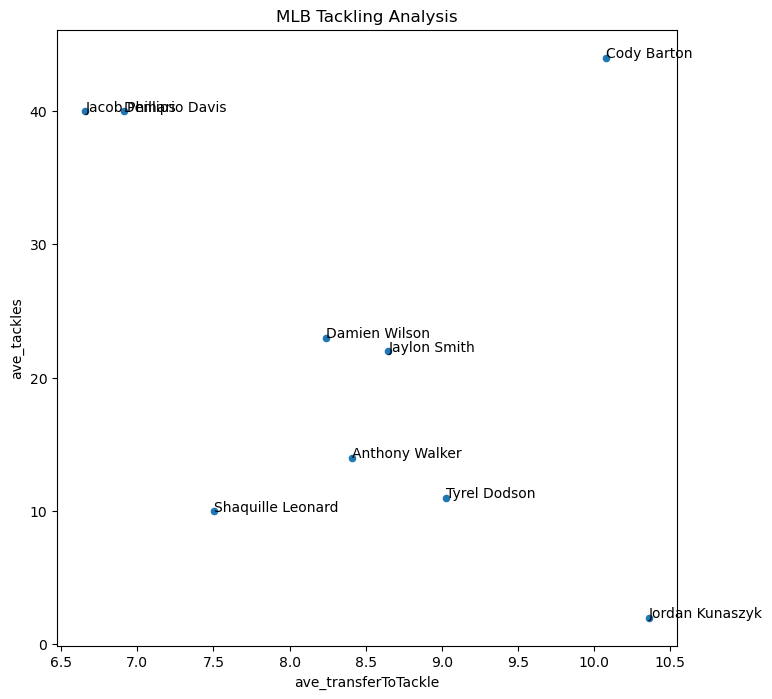

In [265]:
ax = weeks_predict_mlb.plot(kind='scatter', x='ave_transferToTackle', y='ave_tackles', title='MLB Tackling Analysis',
                          figsize=(8,8))
weeks_predict_mlb[['ave_transferToTackle','ave_tackles','displayName']].apply(lambda row: ax.text(*row),axis=1);

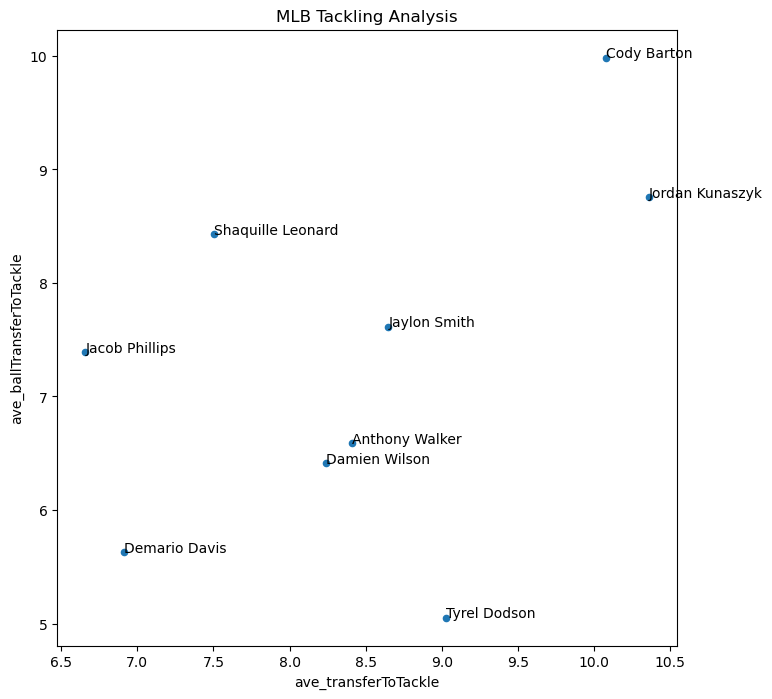

In [266]:
ax = weeks_predict_mlb.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='MLB Tackling Analysis',
                          figsize=(8,8))
weeks_predict_mlb[['ave_transferToTackle','ave_ballTransferToTackle','displayName']].apply(lambda row: ax.text(*row),axis=1);

# Looking At Players On A Team

In [191]:
weeks_predict_matrix

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance,nfId,totalTacklers,tackles
149,2022090800.00,56.00,43294.00,Jalen Ramsey,18.00,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85.00,42489.00,1.00,BUF,LA,6.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0.00,0.00,0.00,0.00,1.00,0.00,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3.00,9.52,43294,1,26
1161,2022090800.00,80.00,53532.00,Ernest Jones,26.00,LA,72.96,42.23,5.62,1.95,0.56,336.48,327.47,tackle,202209080080,1.00,0.00,0.00,0.00,ILB,74.00,1418.33,direct,79.00,46076.00,1.00,BUF,LA,7.00,2.00,4.00,EMPTY,6.00,1.00,LA,BUF,73.10,42.57,0.37,326.47,1.00,7.97,2.77,8.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,73.89,35.52,74.35,39.26,0.00,0.00,72.96,42.23,0.00,0.00,6.77,3.28,6.77,3.77,83.80,83.80,75.53,73.10,0.00,8.27,8.27,2.43,10.70,10.70,2.00,10.77,53532,1,46
1436,2022090800.00,101.00,42816.00,Troy Hill,45.00,LA,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,2022090800101,1.00,0.00,0.00,0.00,CB,71.00,1088.67,run,72.00,47857.00,1.00,BUF,LA,7.00,1.00,10.00,I_FORM,6.00,1.00,LA,BUF,66.69,40.15,2.48,251.22,52.92,1.96,5.41,104.00,286.00,0.00,0.00,0.00,0.00,1.00,0.00,64.67,40.76,69.59,41.88,64.88,42.01,69.08,39.50,1.27,4.71,4.89,2.43,4.59,5.05,79.61,79.16,70.62,66.69,0.45,8.99,8.54,3.93,12.92,12.47,2.00,6.90,42816,1,17
2384,2022090800.00,122.00,38577.00,Bobby Wagner,29.00,LA,60.31,47.90,3.19,2.90,0.33,245.75,289.12,tackle,2022090800122,1.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,65.00,47857.00,1.00,BUF,LA,6.00,2.00,3.00,SHOTGUN,6.00,1.00,LA,BUF,59.89,47.51,0.57,297.47,8.35,4.63,4.21,39.00,35.00,0.00,0.00,0.00,0.00,1.00,0.00,60.07,33.35,62.42,44.97,61.28,35.93,60.31,47.90,2.85,9.11,12.01,3.61,14.55,11.86,68.96,67.89,63.78,59.89,1.07,5.18,4.11,3.89,9.07,8.00,2.00,12.72,38577,1,61
4541,2022090800.00,167.00,43298.00,Leonard Floyd,18.00,LA,46.84,25.08,4.16,6.63,0.46,221.59,237.47,tackle,2022090800167,1.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,57.00,42489.00,1.00,BUF,LA,12.00,2.00,8.00,EMPTY,6.00,1.00,LA,BUF,45.61,24.07,1.59,242.09,4.62,6.41,10.21,30.00,47.00,0.00,0.00,0.00,0.00,1.00,0.00,52.42,32.11,48.44,26.39,51.35,30.31,46.84,25.08,2.09,4.88,6.91,2.07,8.98,6.97,53.30,51.68,47.77,45.61,1.62,5.53,3.91,2.16,7.69,6.07,3.00,9.81,43298,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,2022110700.00,3323.00,52627.00,Geno Stone,42.00,BAL,33.69,3.49,0.74,1.94,0.05,324.57,120.69,tackle,20221107003323,0.00,1.00,0.00,0.00,SS,71.00,1242.50,pass,23.00,54476.00,4.00,NO,BAL,11.00,3.00,14.00,SHOTGUN,6.00,9.00,NO,BAL,34.00,3.54,0.31,118.20,2.49,0.92,2.41,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,32.32,23.49,30.25,8.59,30.65,20.86,33.69,3.49,3.12,12.28,17.63,6.15,20.05,15.04,20.63,21.33,28.71,34.00,0.70,8.08,7.38,5.29,13.37,12.67,3.00,8.52,52627,2,15
12173124,

In [267]:
weeks_predict_kc = weeks_predict_matrix[weeks_predict_matrix['defensiveTeam']=='KC']

In [268]:
weeks_predict_kc

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,transferToTackle,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,ballTransferToTackle,defenseWithin2,aveDefBallDistance,nfId,totalTacklers,tackles
1007971,2022091110.00,347.00,53487.00,Nick Bolton,57.00,KC,34.51,1.84,2.32,6.59,0.23,110.23,142.81,tackle,2022091110347,1.00,0.00,0.00,0.00,ILB,72.00,1392.00,direct,35.00,47784.00,1.00,ARI,KC,-1.00,1.00,10.00,PISTOL,6.00,1.00,ARI,KC,34.84,1.64,0.39,160.95,18.14,3.23,9.17,59.00,166.00,0.00,0.00,0.00,0.00,1.00,0.00,37.72,24.70,34.56,7.90,0.00,0.00,34.51,1.84,0.00,0.00,23.08,6.06,23.08,17.09,30.17,30.17,32.45,34.84,0.00,2.28,2.28,2.39,4.67,4.67,3.00,11.59,53487,1,63
1008734,2022091110.00,379.00,53487.00,Nick Bolton,25.00,KC,43.49,40.72,5.62,1.10,0.56,326.74,0.79,tackle,2022091110379,1.00,0.00,0.00,0.00,ILB,72.00,1392.00,direct,34.00,47784.00,1.00,ARI,KC,10.00,2.00,11.00,SHOTGUN,6.00,1.00,ARI,KC,43.73,41.16,0.50,30.81,30.02,7.82,1.53,235.00,46.00,0.00,0.00,0.00,0.00,1.00,0.00,42.16,30.26,43.47,39.59,0.00,0.00,43.49,40.72,0.00,0.00,10.54,1.13,10.54,9.42,29.82,29.82,43.06,43.73,0.00,13.24,13.24,0.67,13.91,13.91,2.00,11.30,53487,1,63
1018175,2022091110.00,750.00,52546.00,L'Jarius Sneed,48.00,KC,47.60,0.37,0.56,3.23,0.06,148.08,212.66,tackle,2022091110750,1.00,0.00,0.00,1.00,CB,73.00,1174.08,pass,37.00,44917.00,1.00,ARI,KC,11.00,2.00,8.00,SHOTGUN,6.00,1.00,ARI,KC,47.75,0.84,0.49,296.67,84.01,0.66,3.79,55.00,319.00,0.00,0.00,0.00,0.00,1.00,0.00,43.99,20.67,39.60,11.27,43.26,17.70,47.60,0.37,3.06,7.40,17.87,13.52,20.62,10.37,36.15,36.84,38.90,47.75,0.69,2.75,2.06,8.85,11.60,10.91,3.00,13.38,52546,1,44
1019065,2022091110.00,799.00,52546.00,L'Jarius Sneed,31.00,KC,55.78,38.68,2.18,2.23,0.22,280.71,152.50,tackle,2022091110799,1.00,0.00,0.00,0.00,CB,73.00,1174.08,pass,48.00,47808.00,1.00,ARI,KC,9.00,2.00,10.00,SHOTGUN,6.00,1.00,ARI,KC,56.05,38.74,0.28,114.72,37.78,2.56,2.62,97.00,99.00,0.00,0.00,0.00,0.00,1.00,0.00,59.94,33.47,55.78,40.04,58.58,34.16,55.78,38.68,1.53,6.51,5.32,1.36,6.67,7.78,54.70,54.05,55.13,56.05,0.65,0.43,1.08,0.92,1.35,2.00,3.00,7.45,52546,1,44
1021122,2022091110.00,870.00,54486.00,Trent McDuffie,23.00,KC,73.99,15.75,0.53,2.34,0.04,140.35,153.90,tackle,2022091110870,1.00,0.00,0.00,0.00,CB,71.00,1153.75,pass,51.00,48646.00,1.00,ARI,KC,24.00,2.00,18.00,SHOTGUN,6.00,1.00,ARI,KC,74.75,15.60,0.77,39.61,114.29,0.61,2.70,70.00,309.00,0.00,0.00,0.00,0.00,1.00,0.00,69.91,11.52,74.54,15.74,73.11,13.11,73.99,15.75,3.57,2.99,2.78,0.55,5.88,6.26,72.35,74.05,74.48,74.75,1.70,2.13,0.43,0.27,2.40,0.70,2.00,12.54,54486,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12066995,2022110610.00,2792.00,52585.00,Michael Danna,33.00,KC,44.51,7.21,3.00,2.34,0.32,178.24,187.40,tackle,20221106102792,0.00,1.00,0.00,0.00,DE,74.00,1572.50,pass,43.00,54596.00,3.00,TEN,KC,2.00,3.00,14.00,EMPTY,5.00,9.00,KC,TEN,44.60,7.15,0.11,152.07,35.33,4.72,3.68,167.00,130.00,0.00,0.00,0.00,0.00,1.00,0.00,44.05,25.55,44.53,18.88,44.33,22.81,44.51,7.21,2.75,3.94,15.60,11.67,18.35,6.69,37.38,38.34,40.48,44.60,0.96,3.10,2.14,

In [269]:
weeks_predict_kc = weeks_predict_kc[['displayName', 'transferToTackle', 'tackles', 'position', 'ballTransferToTackle']]

In [270]:
weeks_predict_kc

,displayName,transferToTackle,tackles,position,ballTransferToTackle
1007971,Nick Bolton,23.08,63,ILB,4.67
1008734,Nick Bolton,10.54,63,ILB,13.91
1018175,L'Jarius Sneed,17.87,44,CB,10.91
1019065,L'Jarius Sneed,5.32,44,CB,2.00
1021122,Trent McDuffie,2.78,2,CB,0.70
...,...,...,...,...,...
12066995,Michael Danna,15.60,7,DE,6.26
12069404,Khalen Saunders,9.54,26,DT,7.19
12069888,Leo Chenal,8.20,10,OLB,7.19
12069963,Carlos Dunlap,12.92,13,OLB,8.74


In [271]:
weeks_predict_kc['ave_transferToTackle'] = weeks_predict_kc.groupby('displayName')['transferToTackle'].transform('mean')
weeks_predict_kc['ave_ballTransferToTackle'] = weeks_predict_kc.groupby('displayName')['ballTransferToTackle'].transform('mean')

In [272]:
weeks_predict_kc

,displayName,transferToTackle,tackles,position,ballTransferToTackle,ave_transferToTackle,ave_ballTransferToTackle
1007971,Nick Bolton,23.08,63,ILB,4.67,7.39,6.53
1008734,Nick Bolton,10.54,63,ILB,13.91,7.39,6.53
1018175,L'Jarius Sneed,17.87,44,CB,10.91,8.52,8.55
1019065,L'Jarius Sneed,5.32,44,CB,2.00,8.52,8.55
1021122,Trent McDuffie,2.78,2,CB,0.70,31.44,30.44
...,...,...,...,...,...,...,...
12066995,Michael Danna,15.60,7,DE,6.26,7.89,7.49
12069404,Khalen Saunders,9.54,26,DT,7.19,7.34,7.17
12069888,Leo Chenal,8.20,10,OLB,7.19,7.33,7.90
12069963,Carlos Dunlap,12.92,13,OLB,8.74,8.04,6.96


In [273]:
weeks_predict_kc = weeks_predict_kc.drop_duplicates('displayName', keep='first')
weeks_predict_kc = weeks_predict_kc.drop('transferToTackle', axis=1)
weeks_predict_kc = weeks_predict_kc.drop('ballTransferToTackle', axis=1)

In [274]:
weeks_predict_kc

,displayName,tackles,position,ave_transferToTackle,ave_ballTransferToTackle
1007971,Nick Bolton,63,ILB,7.39,6.53
1018175,L'Jarius Sneed,44,CB,8.52,8.55
1021122,Trent McDuffie,2,CB,31.44,30.44
1036327,Rashad Fenton,16,CB,5.57,5.96
1042697,Justin Reid,28,SS,9.78,11.59
1048574,Willie Gay,25,OLB,6.20,5.45
1061549,Bryan Cook,11,SS,7.02,5.84
1064476,Frank Clark,12,DE,6.99,7.12
1067835,Juan Thornhill,28,FS,7.80,9.78
1079534,George Karlaftis,16,DE,8.70,7.93


To eliminate an outlier with low tackles, but very high average transfer to tackle. 

In [275]:
weeks_predict_kc = weeks_predict_kc[weeks_predict_kc.displayName != 'Trent McDuffie']
weeks_predict_kc = weeks_predict_kc[weeks_predict_kc.displayName != 'Deon Bush']

In [276]:
weeks_predict_kc['displayName'].nunique()

23

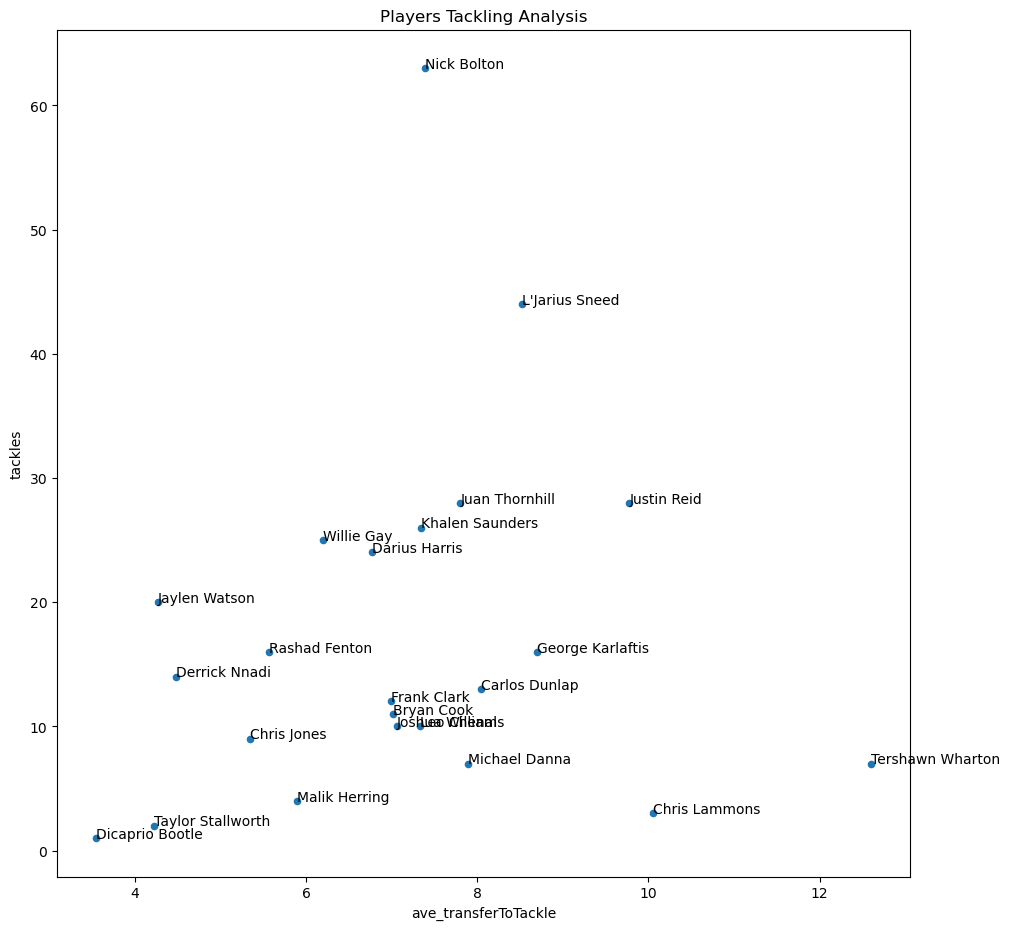

In [277]:
ax = weeks_predict_kc.plot(kind='scatter', x='ave_transferToTackle', y='tackles', title='Players Tackling Analysis',
                          figsize=(11,11))
weeks_predict_kc[['ave_transferToTackle','tackles','displayName']].apply(lambda row: ax.text(*row),axis=1);

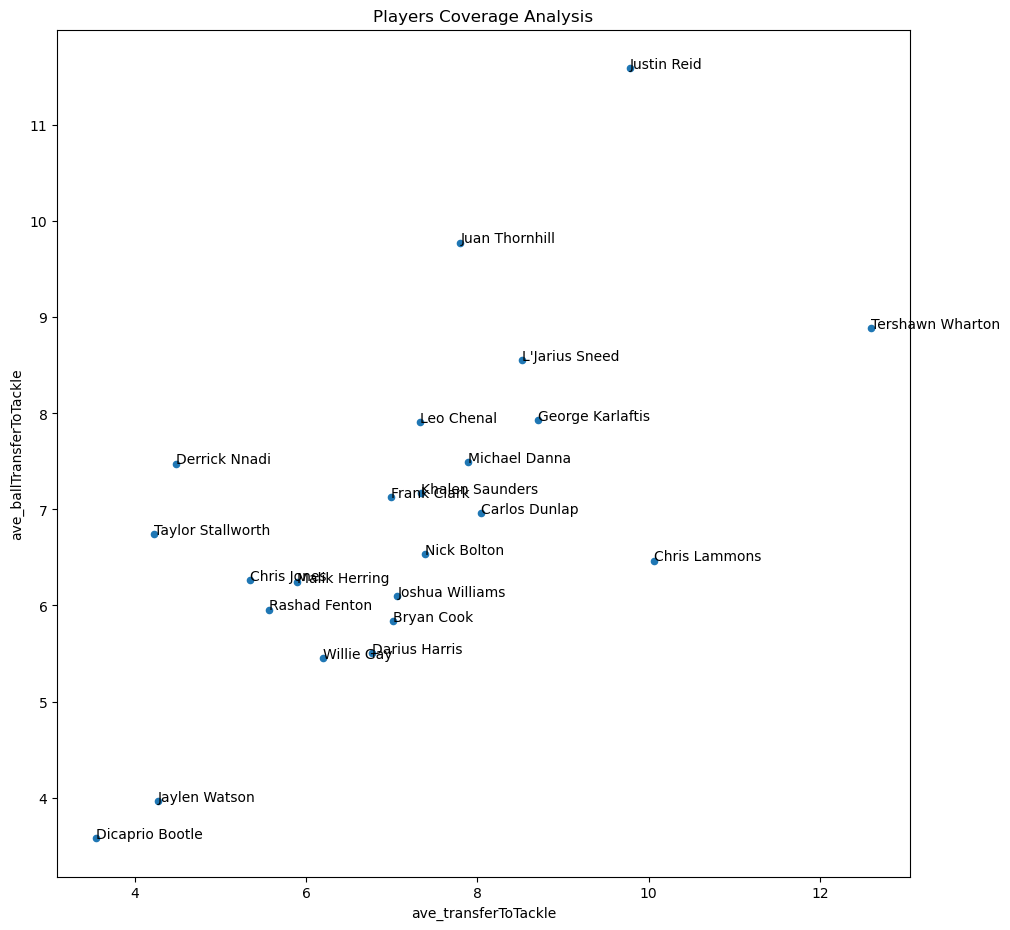

In [279]:
ax = weeks_predict_kc.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Players Coverage Analysis',
                          figsize=(11,11))
weeks_predict_kc[['ave_transferToTackle','ave_ballTransferToTackle','displayName']].apply(lambda row: ax.text(*row),axis=1);

In [280]:
weeks_predict_kc['ave_transferToTackle'].describe()

count   23.00
mean     7.08
std      2.09
min      3.55
25%      5.73
50%      7.07
75%      7.97
max     12.60
Name: ave_transferToTackle, dtype: float64

For the overall dataset of over 13,000 rows the linear regression equation is y = 0.64x + 2.3224.

In [464]:
y = .64*7+2.3225
y

6.8025

In [466]:
weeks_predict_kc.loc[-1] = ["L'Jarius Sneed v2", 44, 'CB', 7, 6.8025]

In [467]:
weeks_predict_kc

,displayName,tackles,position,ave_transferToTackle,ave_ballTransferToTackle
1007971,Nick Bolton,63,ILB,7.39,6.53
1018175,L'Jarius Sneed,44,CB,8.52,8.55
1036327,Rashad Fenton,16,CB,5.57,5.96
1042697,Justin Reid,28,SS,9.78,11.59
1048574,Willie Gay,25,OLB,6.20,5.45
1061549,Bryan Cook,11,SS,7.02,5.84
1064476,Frank Clark,12,DE,6.99,7.12
1067835,Juan Thornhill,28,FS,7.80,9.78
1079534,George Karlaftis,16,DE,8.70,7.93
1080056,Khalen Saunders,26,DT,7.34,7.17


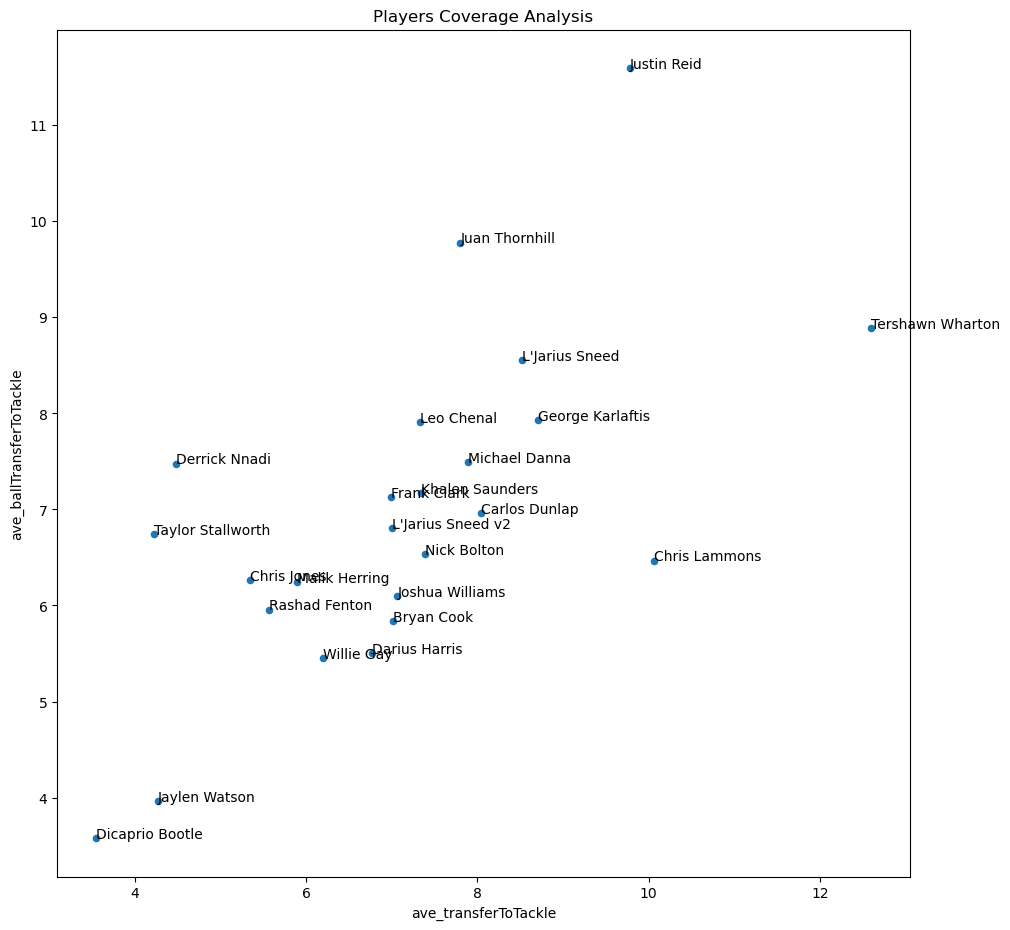

In [468]:
ax = weeks_predict_kc.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Players Coverage Analysis',
                          figsize=(11,11))
weeks_predict_kc[['ave_transferToTackle','ave_ballTransferToTackle','displayName']].apply(lambda row: ax.text(*row),axis=1);

# Looking at Overall Teams

In [281]:
weeks_predict_teams = weeks_predict_matrix.copy()

In [282]:
weeks_predict_teams = weeks_predict_teams[['transferToTackle', 'playResult', 'defensiveTeam', 'ballTransferToTackle']]
weeks_predict_teams['ave_transferToTackle'] = weeks_predict_teams.groupby('defensiveTeam')['transferToTackle'].transform('mean')
weeks_predict_teams['ave_ballTransferToTackle'] = weeks_predict_teams.groupby('defensiveTeam')['ballTransferToTackle'].transform('mean')
weeks_predict_teams['ave_playResult'] = weeks_predict_teams.groupby('defensiveTeam')['playResult'].transform('mean')
weeks_predict_teams = weeks_predict_teams.drop_duplicates('defensiveTeam', keep='first')
weeks_predict_teams = weeks_predict_teams.drop('transferToTackle', axis=1)
weeks_predict_teams = weeks_predict_teams.drop('ballTransferToTackle', axis=1)
weeks_predict_teams = weeks_predict_teams.drop('playResult', axis=1)

In [563]:
weeks_predict_teams

,defensiveTeam,ave_transferToTackle,ave_ballTransferToTackle,ave_playResult
149,LA,7.03,7.29,5.28
8001,BUF,8.30,6.78,5.69
80173,NO,7.01,6.73,5.17
86075,ATL,7.07,7.20,6.57
173002,CLE,7.68,7.91,5.96
176027,CAR,7.74,6.99,5.32
265570,SF,7.57,7.06,5.61
267111,CHI,8.04,7.82,6.23
372722,CIN,7.65,7.57,6.09
376049,PIT,7.16,7.09,6.22


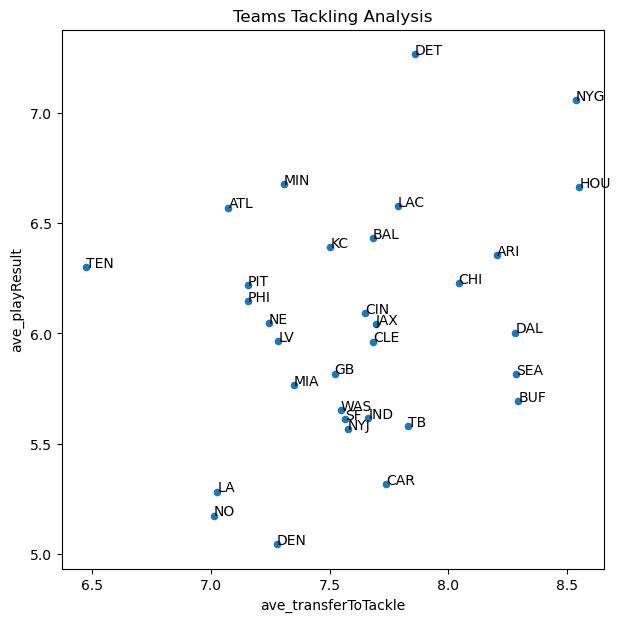

In [283]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_transferToTackle', y='ave_playResult', title='Teams Tackling Analysis',
                          figsize=(7,7))
weeks_predict_teams[['ave_transferToTackle','ave_playResult','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

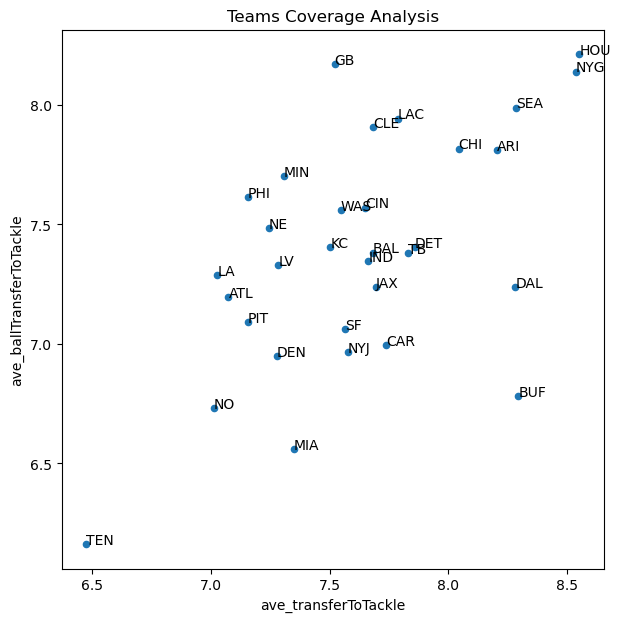

In [284]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Teams Coverage Analysis',
                          figsize=(7,7))
weeks_predict_teams[['ave_transferToTackle','ave_ballTransferToTackle','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

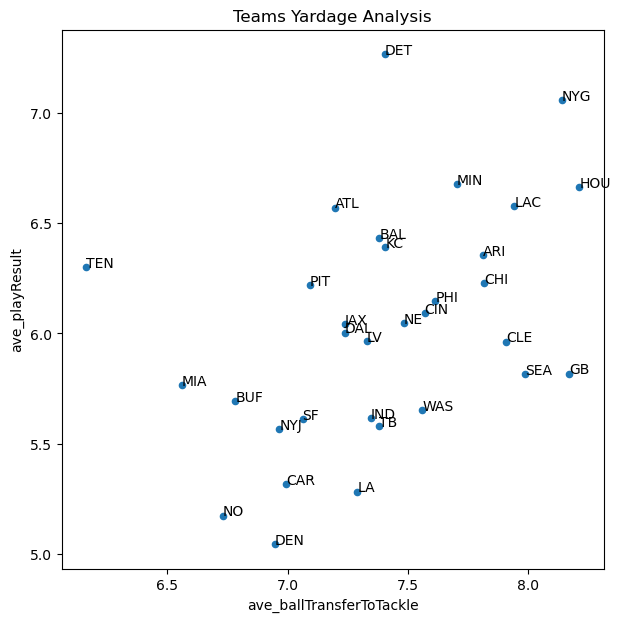

In [286]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_ballTransferToTackle', y='ave_playResult', title='Teams Yardage Analysis',
                          figsize=(7,7))
weeks_predict_teams[['ave_ballTransferToTackle','ave_playResult','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

In [565]:
y = .64*7 + 2.3224
y

6.8024000000000004

In [566]:
weeks_predict_teams.loc[-1] = ["KC v2", 7, 6.8024, 6.39]

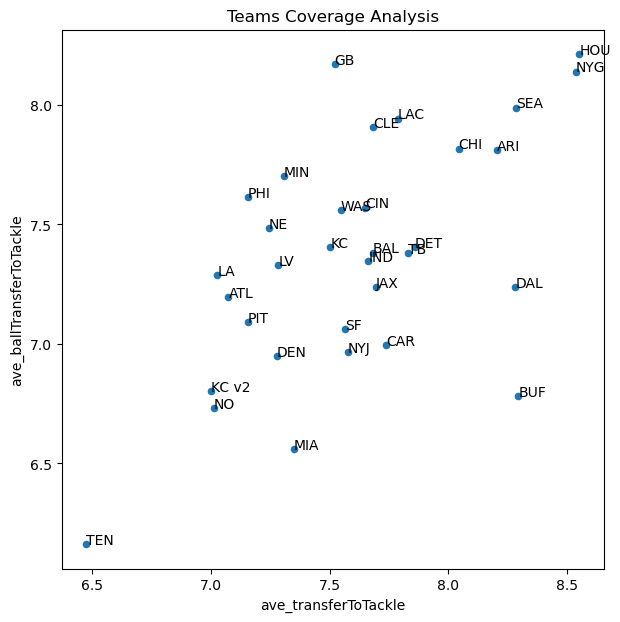

In [567]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Teams Coverage Analysis',
                          figsize=(7,7))
weeks_predict_teams[['ave_transferToTackle','ave_ballTransferToTackle','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

In [288]:
weeks_predict_teams_run = weeks_predict_matrix[weeks_predict_matrix['playType']=='run']
weeks_predict_teams_pass = weeks_predict_matrix[weeks_predict_matrix['playType']=='pass']

In [289]:
weeks_predict_teams_run = weeks_predict_teams_run[['transferToTackle', 'playResult', 'defensiveTeam', 'ballTransferToTackle']]
weeks_predict_teams_run['ave_transferToTackle'] = weeks_predict_teams_run.groupby('defensiveTeam')['transferToTackle'].transform('mean')
weeks_predict_teams_run['ave_ballTransferToTackle'] = weeks_predict_teams_run.groupby('defensiveTeam')['ballTransferToTackle'].transform('mean')
weeks_predict_teams_run['ave_playResult'] = weeks_predict_teams_run.groupby('defensiveTeam')['playResult'].transform('mean')
weeks_predict_teams_run = weeks_predict_teams_run.drop_duplicates('defensiveTeam', keep='first')
weeks_predict_teams_run = weeks_predict_teams_run.drop('transferToTackle', axis=1)
weeks_predict_teams_run = weeks_predict_teams_run.drop('ballTransferToTackle', axis=1)
weeks_predict_teams_run = weeks_predict_teams_run.drop('playResult', axis=1)

In [290]:
weeks_predict_teams_pass = weeks_predict_teams_pass[['transferToTackle', 'playResult', 'defensiveTeam', 'ballTransferToTackle']]
weeks_predict_teams_pass['ave_transferToTackle'] = weeks_predict_teams_pass.groupby('defensiveTeam')['transferToTackle'].transform('mean')
weeks_predict_teams_pass['ave_ballTransferToTackle'] = weeks_predict_teams_pass.groupby('defensiveTeam')['ballTransferToTackle'].transform('mean')
weeks_predict_teams_pass['ave_playResult'] = weeks_predict_teams_pass.groupby('defensiveTeam')['playResult'].transform('mean')
weeks_predict_teams_pass = weeks_predict_teams_pass.drop_duplicates('defensiveTeam', keep='first')
weeks_predict_teams_pass = weeks_predict_teams_pass.drop('transferToTackle', axis=1)
weeks_predict_teams_pass = weeks_predict_teams_pass.drop('ballTransferToTackle', axis=1)
weeks_predict_teams_pass = weeks_predict_teams_pass.drop('playResult', axis=1)

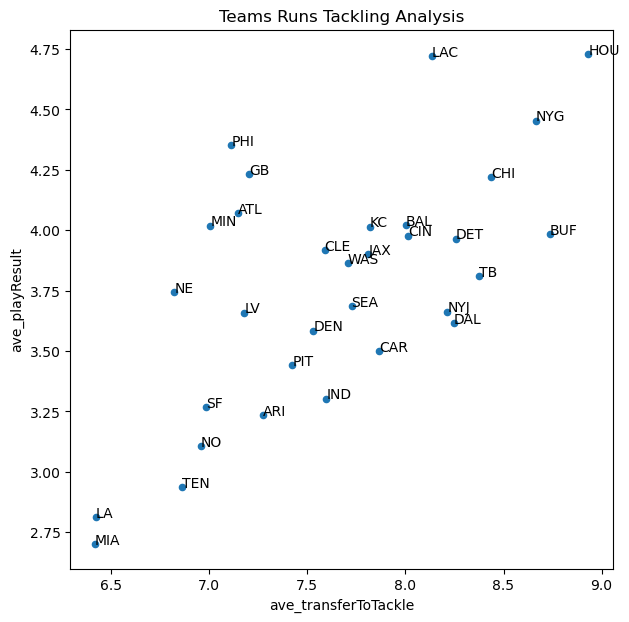

In [294]:
ax = weeks_predict_teams_run.plot(kind='scatter', x='ave_transferToTackle', y='ave_playResult', title='Teams Runs Tackling Analysis',
                          figsize=(7,7))
weeks_predict_teams_run[['ave_transferToTackle','ave_playResult','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

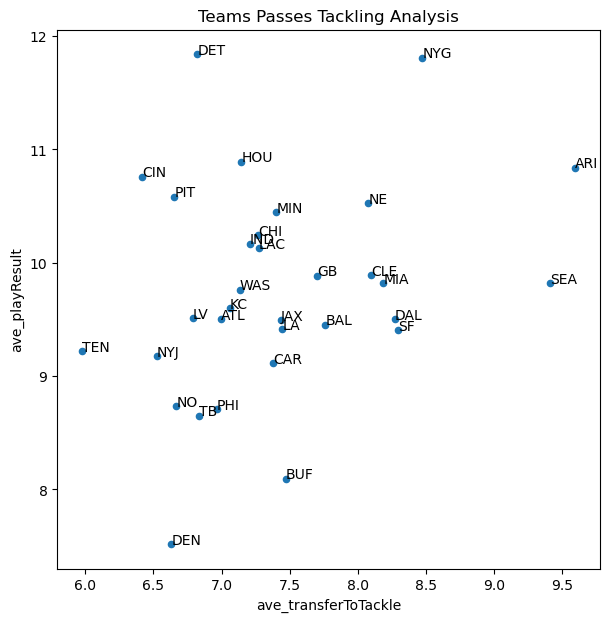

In [211]:
ax = weeks_predict_teams_pass.plot(kind='scatter', x='ave_transferToTackle', y='ave_playResult', title='Teams Passes Tackling Analysis',
                          figsize=(7,7))
weeks_predict_teams_pass[['ave_transferToTackle','ave_playResult','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

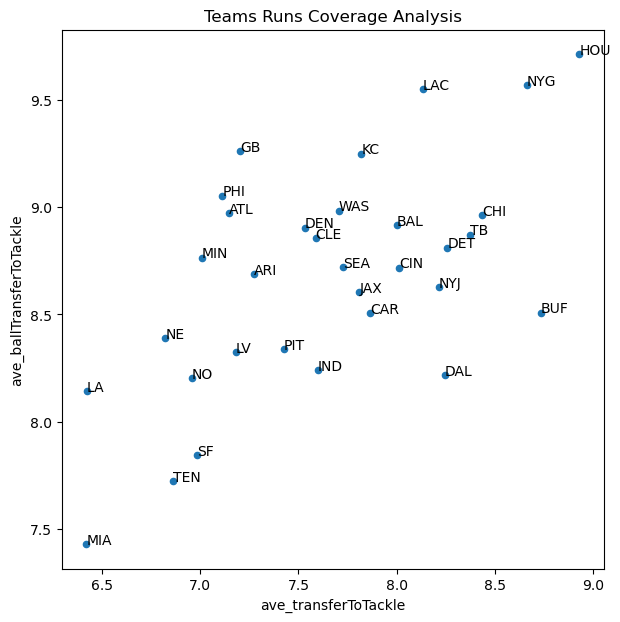

In [298]:
ax = weeks_predict_teams_run.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Teams Runs Coverage Analysis',
                          figsize=(7,7))
weeks_predict_teams_run[['ave_transferToTackle','ave_ballTransferToTackle','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

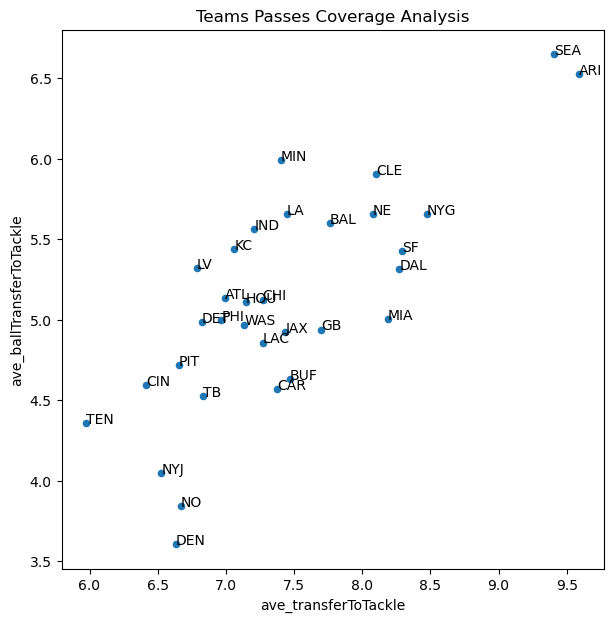

In [296]:
ax = weeks_predict_teams_pass.plot(kind='scatter', x='ave_transferToTackle', y='ave_ballTransferToTackle', title='Teams Passes Coverage Analysis',
                          figsize=(7,7))
weeks_predict_teams_pass[['ave_transferToTackle','ave_ballTransferToTackle','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

# Effects of Offensive & Defensive Formations

In [212]:
weeks_predict.head(5)

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_transferToTackle,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ballTransferToTackle,defenseWithin2,aveDefBallDistance,totalTacklers,tackles,ballTransferToTackleQuartiles,ballTransferToTackleEighths
149,202209080056,1.00,0.00,1265.33,1,85.00,1.00,16,1.00,10.00,5,6.00,0.67,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26,Under 3.05,"(-0.001, 1.22]"
1161,202209080080,1.00,0.00,1418.33,0,79.00,1.00,16,2.00,4.00,1,6.00,0.37,1.00,7.97,2.77,8.00,3.00,0.00,0.00,6.77,3.28,6.77,3.77,10.70,2.00,10.77,1,46,Over 9.66,"(9.66, 12.62]"
1436,2022090800101,1.00,0.00,1088.67,2,72.00,1.00,16,1.00,10.00,2,6.00,2.48,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17,Over 9.66,"(9.66, 12.62]"
2384,2022090800122,1.00,0.00,1452.00,1,65.00,1.00,16,2.00,3.00,5,6.00,0.57,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61,6.40-9.66,"(7.95, 9.66]"
4541,2022090800167,1.00,0.00,1540.00,1,57.00,1.00,16,2.00,8.00,1,6.00,1.59,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31,3.05-6.40,"(4.83, 6.4]"


In [213]:
weeks_predict['ave_defendersInTheBox'].value_counts()

6.00     4424
7.00     3043
8.00     1209
5.00      919
4.00      255
9.00      114
3.00       37
10.00      22
11.00       8
0.00        3
1.00        1
Name: ave_defendersInTheBox, dtype: int64

In [214]:
weeks_predict['offenseFormation'].value_counts()

5    4972
6    2979
2     799
1     640
4     489
3      80
7      73
0       3
Name: offenseFormation, dtype: int64

In [215]:
formations

,ave_defendersInTheBox,offenseFormation,ballTransferToTackle,defensiveTeam
149,6.00,SHOTGUN,0.52,LA
1161,6.00,EMPTY,10.70,LA
1436,6.00,I_FORM,12.47,LA
2384,6.00,SHOTGUN,8.00,LA
4541,6.00,EMPTY,6.07,LA
...,...,...,...,...
12140438,6.00,PISTOL,5.14,NO
12150622,7.00,WILDCAT,11.80,BAL
12171983,6.00,SHOTGUN,12.67,BAL
12173124,6.00,SHOTGUN,1.85,BAL


In [216]:
formations['defensiveTeam'].value_counts()

ATL    377
CAR    367
IND    349
ARI    343
TB     334
JAX    332
SEA    329
CHI    326
CIN    326
PIT    326
MIA    325
NYJ    324
GB     322
LV     322
DAL    315
WAS    315
NO     315
DEN    314
DET    312
HOU    307
BAL    305
KC     302
MIN    301
LA     301
TEN    299
NE     296
LAC    292
BUF    291
PHI    280
CLE    267
NYG    264
SF     257
Name: defensiveTeam, dtype: int64

In [217]:
formations = formations[formations.offenseFormation != 'JUMBO']
formations = formations[formations.offenseFormation != 'WILDCAT']
formations = formations[formations.offenseFormation != 'PISTOL']
formations = formations[formations.ave_defendersInTheBox != 1]
formations = formations[formations.ave_defendersInTheBox != 11]
formations = formations[formations.ave_defendersInTheBox != 10]
formations = formations[formations.ave_defendersInTheBox != 9]
formations = formations[formations.ave_defendersInTheBox != 3]

In [218]:
table = pd.pivot_table(formations, values='ballTransferToTackle', index=['ave_defendersInTheBox'],
                       columns=['offenseFormation'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

offenseFormation,0,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,,
Overall,4.43,5.36,8.39,6.55,8.30,7.18
0.0,4.43,NaN,NaN,NaN,NaN,4.43
5.0,NaN,5.24,3.66,6.35,9.07,6.10
4.0,NaN,5.88,7.21,6.75,5.38,6.45
6.0,NaN,5.30,7.99,6.58,8.66,7.01
7.0,NaN,5.47,8.50,6.48,8.35,7.64
8.0,NaN,3.69,8.44,6.86,7.61,7.67


In [219]:
table_amount = pd.pivot_table(formations, values='ballTransferToTackle', index=['ave_defendersInTheBox'],
                       columns=['offenseFormation'], aggfunc="sum", margins="True", margins_name='Overall')
table_amount = table_amount.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table_amount

offenseFormation,0,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,,
0.0,13.30,NaN,NaN,NaN,NaN,13.30
4.0,NaN,505.91,14.43,1113.94,10.76,1645.04
5.0,NaN,1314.88,3.66,4006.71,190.47,5515.72
8.0,NaN,3.69,2252.62,1420.36,4674.06,8350.73
7.0,NaN,213.34,3280.40,6697.85,11187.19,21378.78
6.0,NaN,1314.45,918.41,19027.10,8255.54,29515.50
Overall,13.30,3352.27,6469.52,32265.96,24318.02,66419.07


In [220]:
formations_ten = formations[formations['defensiveTeam']=='TEN']
formations_ten

,ave_defendersInTheBox,offenseFormation,ballTransferToTackle,defensiveTeam
829506,7.00,SHOTGUN,4.82,TEN
835935,6.00,SHOTGUN,0.09,TEN
837037,7.00,SHOTGUN,8.15,TEN
837627,6.00,SHOTGUN,2.17,TEN
840569,4.00,SHOTGUN,9.57,TEN
...,...,...,...,...
12079270,6.00,SHOTGUN,5.59,TEN
12080918,6.00,SHOTGUN,2.79,TEN
12086425,7.00,I_FORM,4.14,TEN
12089206,6.00,SHOTGUN,3.65,TEN


In [221]:
table = pd.pivot_table(formations_ten, values='ballTransferToTackle', index=['ave_defendersInTheBox'],
                       columns=['offenseFormation'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

offenseFormation,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,
Overall,3.99,6.46,5.49,6.59,5.78
8.0,NaN,4.68,NaN,2.71,3.84
4.0,1.58,NaN,6.45,NaN,5.23
5.0,0.48,NaN,5.58,3.03,5.36
6.0,6.77,3.53,5.54,6.87,5.76
7.0,NaN,7.50,4.73,6.90,6.41


In [222]:
formations_hou = formations[formations['defensiveTeam']=='HOU']
formations_hou

,ave_defendersInTheBox,offenseFormation,ballTransferToTackle,defensiveTeam
564247,6.00,SINGLEBACK,6.74,HOU
568750,7.00,SINGLEBACK,5.36,HOU
570044,7.00,SINGLEBACK,3.64,HOU
573042,7.00,SHOTGUN,10.69,HOU
573828,6.00,SINGLEBACK,9.39,HOU
...,...,...,...,...
10219905,8.00,SINGLEBACK,3.02,HOU
11070030,7.00,SHOTGUN,8.33,HOU
11073533,8.00,SINGLEBACK,2.96,HOU
11074968,7.00,SINGLEBACK,11.52,HOU


In [223]:
table = pd.pivot_table(formations_hou, values='ballTransferToTackle', index=['ave_defendersInTheBox'],
                       columns=['offenseFormation'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

offenseFormation,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,
Overall,5.66,11.68,7.03,8.98,8.17
5.0,3.94,NaN,7.80,NaN,6.17
6.0,9.99,11.34,7.00,9.53,7.98
7.0,2.76,13.04,5.65,8.62,8.76
8.0,NaN,10.19,5.75,8.49,8.87
4.0,4.99,NaN,11.70,NaN,9.46
